In [1]:
import pandas

In [2]:
df1 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data.csv')
df2 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data5:37.csv')
df3 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data5:47.csv')
df4 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data6:37.csv')

In [3]:
print(df1["number"].isna().mean() * 100)
print(df2["number"].isna().mean() * 100)
print(df3["number"].isna().mean() * 100)
print(df4["number"].isna().mean() * 100)

22.8643216080402
26.884422110552762
27.1356783919598
13.651591289782244


In [4]:
percent = (df1["number"].isna() & df2["number"].isna() & df3["number"].isna() & df4["number"].isna()).mean() * 100
print(percent)

2.3450586264656614


In [5]:
import pandas as pd

def bigger_half(a, b):
    return a + b / 2

def merge_number_columns(df1: pd.DataFrame, df2: pd.DataFrame, col: str = "number") -> pd.Series:
    s1 = df1[col]
    s2 = df2[col]

    return s1.combine(s2, lambda a, b: bigger_half(a, b) if pd.notna(a) and pd.notna(b) else a if pd.notna(a) else b)

In [6]:
print(df1["number"].mean(), df2["number"].mean(), df3["number"].mean(), df4["number"].mean())

33.01028230184582 33.66439862542955 31.749942528735637 31.9221629485936


In [7]:
df = pandas.DataFrame()
df["number"] = merge_number_columns(df1, df2)
df["number"] = merge_number_columns(df, df3)
df["number"] = merge_number_columns(df, df4)
df["date"] = df1["date"]
df["link"] = df1["link"]
df = df[df["number"] <= 65]
print(df["number"].isna().mean() * 100)
print(df["number"].mean())

0.0
38.5013973063973


In [8]:
df = df.dropna(subset=["number"])

q1 = df["number"].quantile(0.25)
q3 = df["number"].quantile(0.75)
iqr = q3 - q1

df = df[(df["number"] >= q1 - 1.5 * iqr) & (df["number"] <= q3 + 1.5 * iqr)]

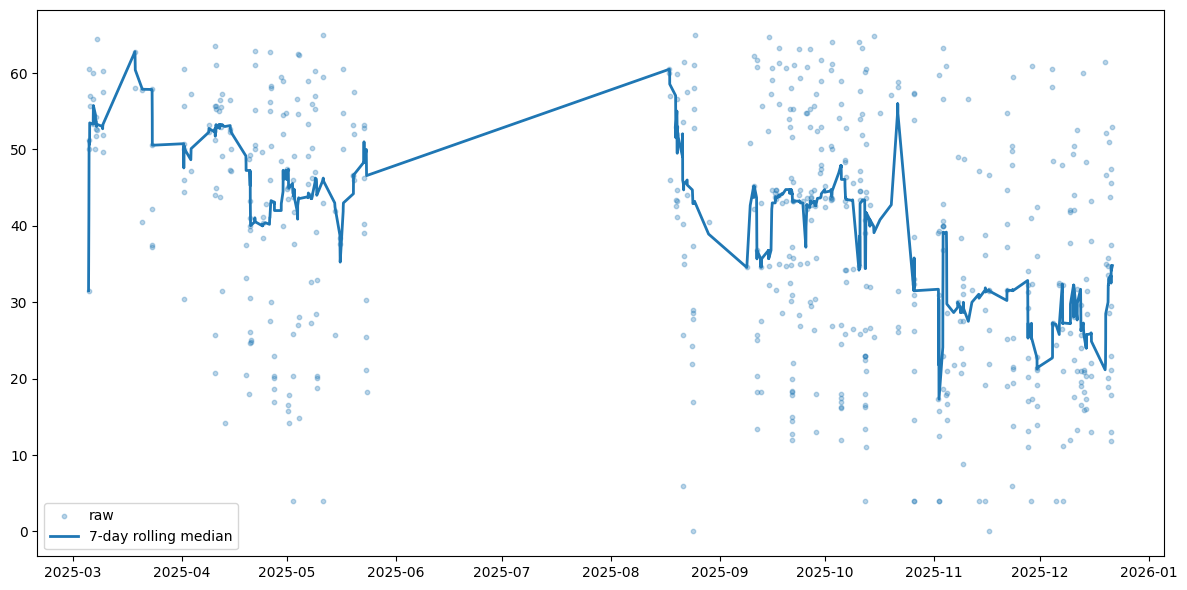

In [9]:
import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.tz_convert(None)
df = df.dropna(subset=["date", "number"])


df = df.sort_values("date")

plt.figure(figsize=(12, 6))

# сырые точки
plt.scatter(
    df["date"],
    df["number"],
    s=10,
    alpha=0.3,
    label="raw"
)

df = df.set_index("date")
# сглаживание: rolling median (устойчив к выбросам)
smoothed = (
    df
    ["number"]
    .rolling("7D", min_periods=1)
    .median()
)

plt.plot(
    smoothed.index,
    smoothed.values,
    linewidth=2,
    label="7-day rolling median"
)

plt.legend()
plt.tight_layout()
plt.show()


In [10]:
df_hi = df[df["number"] > 30]
df_hi = df_hi[df_hi["number"] < 65]
df_lo = df[df["number"] <= 30]

In [11]:
import matplotlib.pyplot as plt

def plot_ts(df: pandas.DataFrame, title):
    df = df.sort_values("date")

    plt.figure(figsize=(12, 5))

    plt.scatter(
        df.index,
        df["number"],
        s=10,
        alpha=0.3,
        label="raw"
    )

    smoothed = (
        df
        ["number"]
        .rolling("7D", min_periods=1)
        .median()
    )

    plt.plot(
        smoothed.index,
        smoothed.values,
        linewidth=2,
        label="7-day rolling median"
    )

    if "real_price" in df.keys():
        smoothed = (
            df
            ["real_price"]
            .rolling("7D", min_periods=1)
            .median()
        )

        plt.plot(
            smoothed.index,
            smoothed.values,
            linewidth=2,
            label="7-day rolling real price",
        )

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


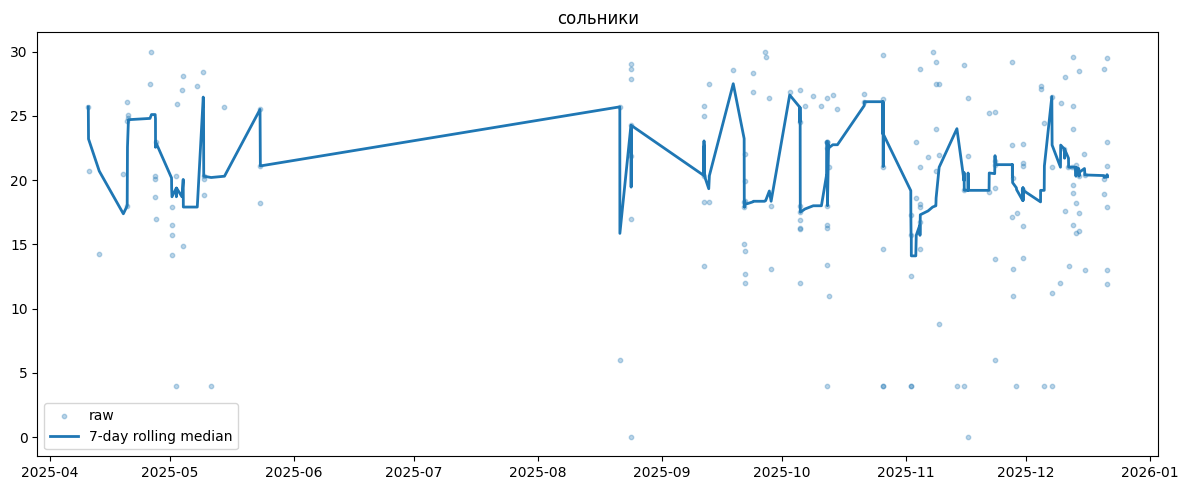

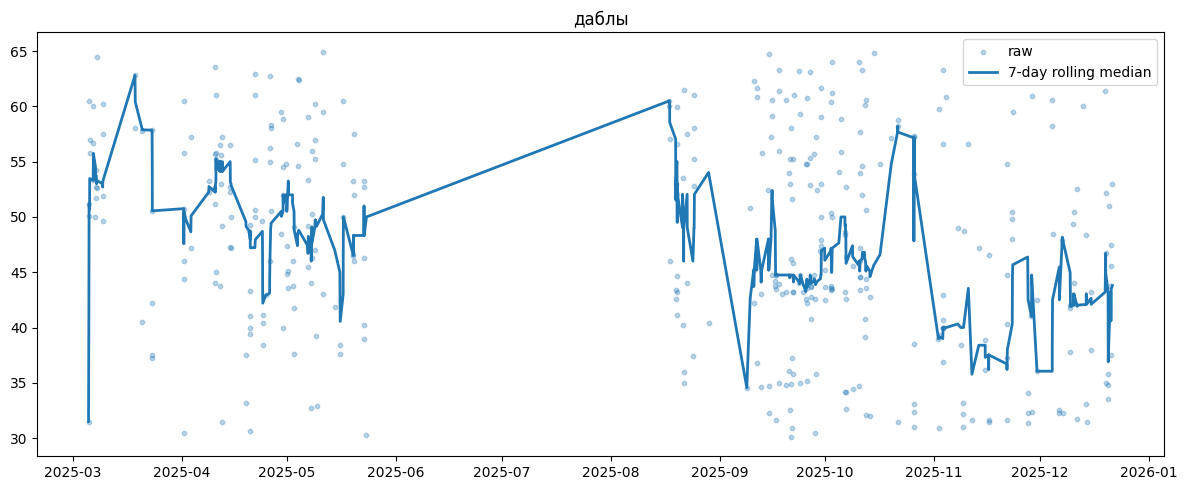

In [12]:
plot_ts(df_lo, "сольники")
plot_ts(df_hi, "даблы")

In [13]:
pct_lo = df_lo["number"].pct_change() * 100
pct_hi = df_hi["number"].pct_change() * 100

low, high = pct_lo.quantile([0.01, 0.99])
pct_lo = pct_lo.clip(low, high)

low, high = pct_hi.quantile([0.01, 0.99])
pct_hi = pct_hi.clip(low, high)


In [14]:
def plot_percent(df_pct):

    plt.figure(figsize=(12, 5))

    plt.plot(df_pct.index, df_pct.values, linewidth=1)
    plt.axhline(0, linestyle="--", alpha=0.5)

    plt.title("Percentage change of price")
    plt.ylabel("% change")
    plt.tight_layout()

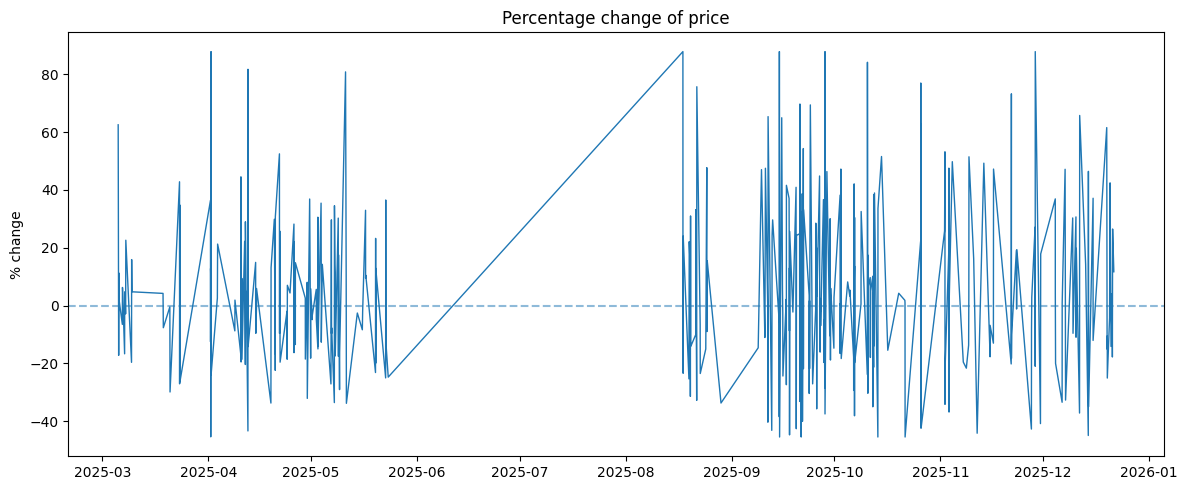

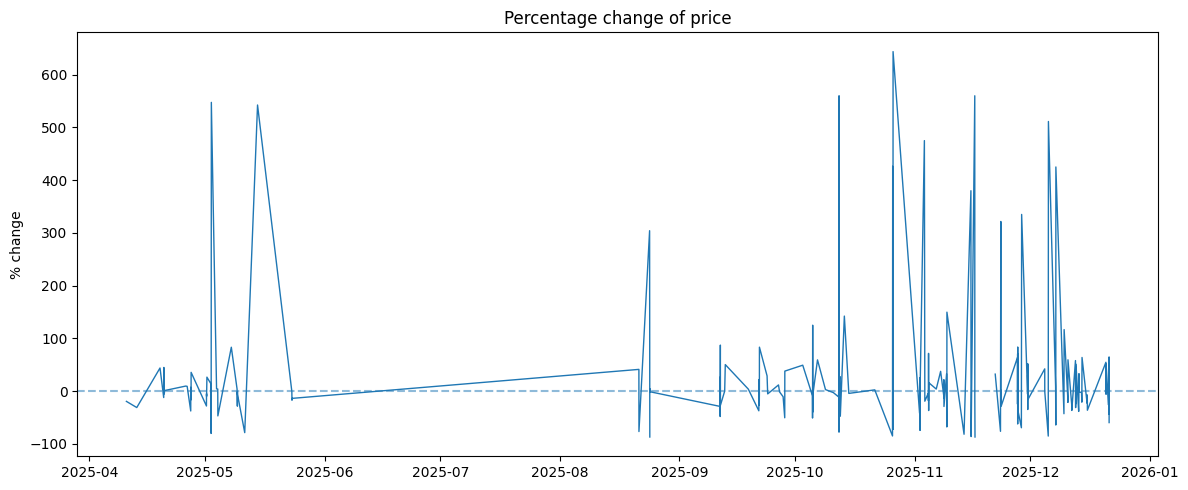

In [15]:
plot_percent(pct_hi)
plot_percent(pct_lo)

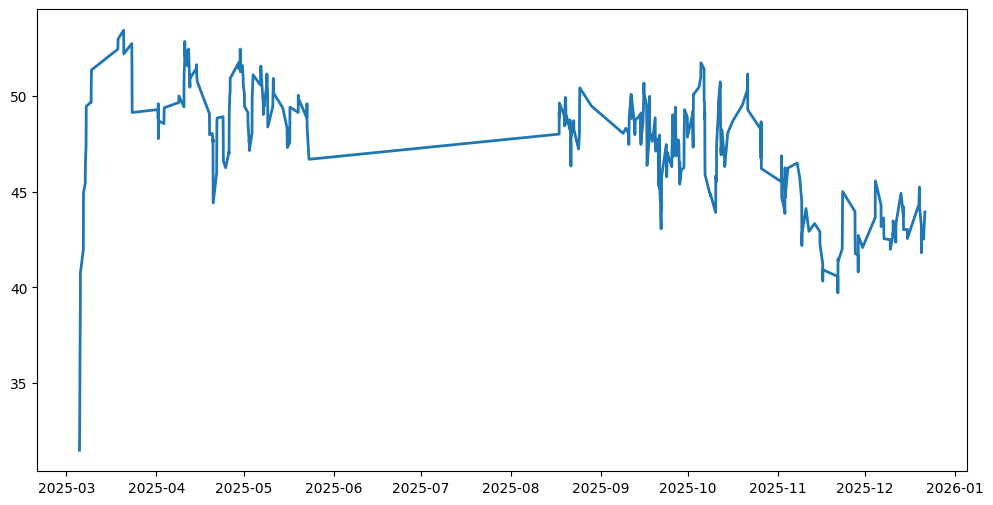

In [16]:
import matplotlib.pyplot as plt

df = df.sort_values("date")

plt.figure(figsize=(12, 6))

ema = (
    df_hi
    ["number"]
    .ewm(span=20, adjust=False)
    .mean()
)

plt.plot(ema.index, ema.values, linewidth=2, label="EMA")



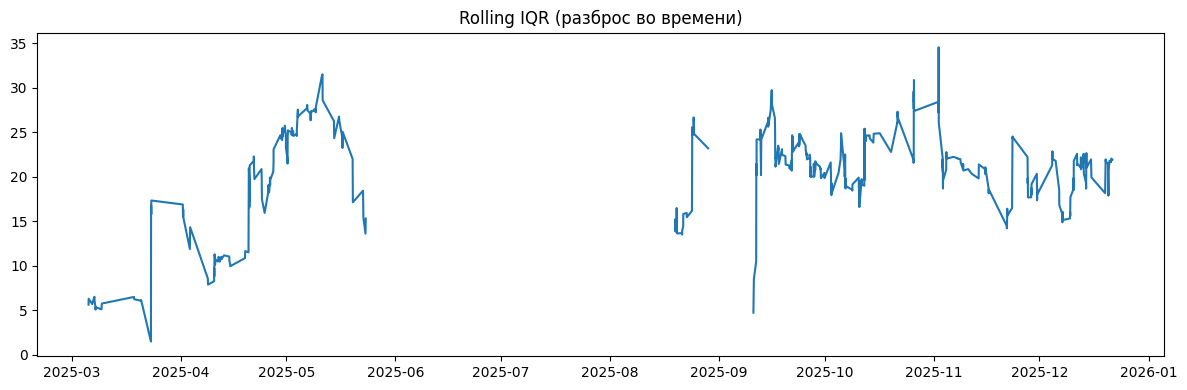

In [17]:
s = df["number"]

q75 = s.rolling("14D", min_periods=5).quantile(0.75)
q25 = s.rolling("14D", min_periods=5).quantile(0.25)
rolling_iqr = q75 - q25

plt.figure(figsize=(12, 4))
plt.plot(rolling_iqr.index, rolling_iqr.values)
plt.title("Rolling IQR (разброс во времени)")
plt.tight_layout()
plt.show()


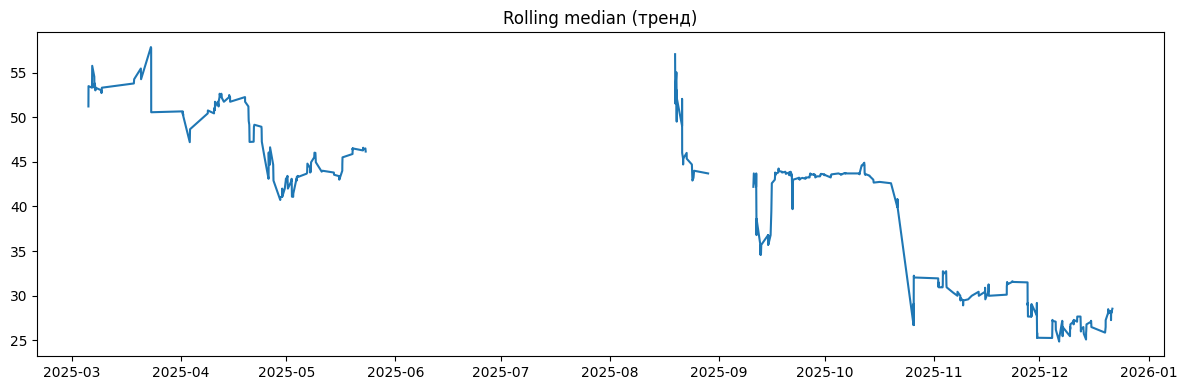

In [18]:
trend = df["number"].rolling("14D", min_periods=5).median()
plt.figure(figsize=(12, 4))
plt.plot(trend.index, trend.values)
plt.title("Rolling median (тренд)")
plt.tight_layout()
plt.show()


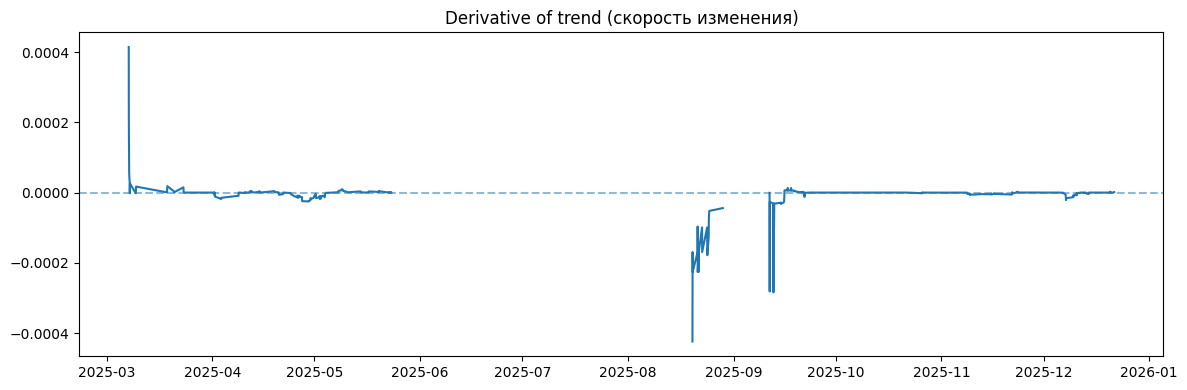

In [19]:
dt = trend.index.to_series().diff().dt.total_seconds()
dtrend = trend.diff() / dt
dtrend_smooth = dtrend.rolling("14D", min_periods=5).median()
plt.figure(figsize=(12, 4))
plt.plot(dtrend_smooth.index, dtrend_smooth.values)
plt.axhline(0, linestyle="--", alpha=0.5)
plt.title("Derivative of trend (скорость изменения)")
plt.tight_layout()
plt.show()


In [20]:
diqr = rolling_iqr.diff()
mid = len(trend) // 2
print(trend.iloc[:mid].median(), trend.iloc[mid:].median())


44.675 31.275


In [21]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
groups = pd.cut(df["number"], bins=bins)

counts = groups.value_counts().sort_index()
print(counts)

number
(0, 10]      15
(10, 20]     72
(20, 30]    107
(30, 40]     91
(40, 50]    136
(50, 60]    124
(60, 70]     46
(70, 80]      0
Name: count, dtype: int64


In [22]:
trend = df["number"].rolling("14D", min_periods=5).median()
dt = trend.index.to_series().diff().dt.total_seconds()
d1 = trend.diff() / dt
d2 = d1.diff() / dt
d1_s = d1.rolling("14D", min_periods=5).median()
d2_s = d2.rolling("14D", min_periods=5).median()


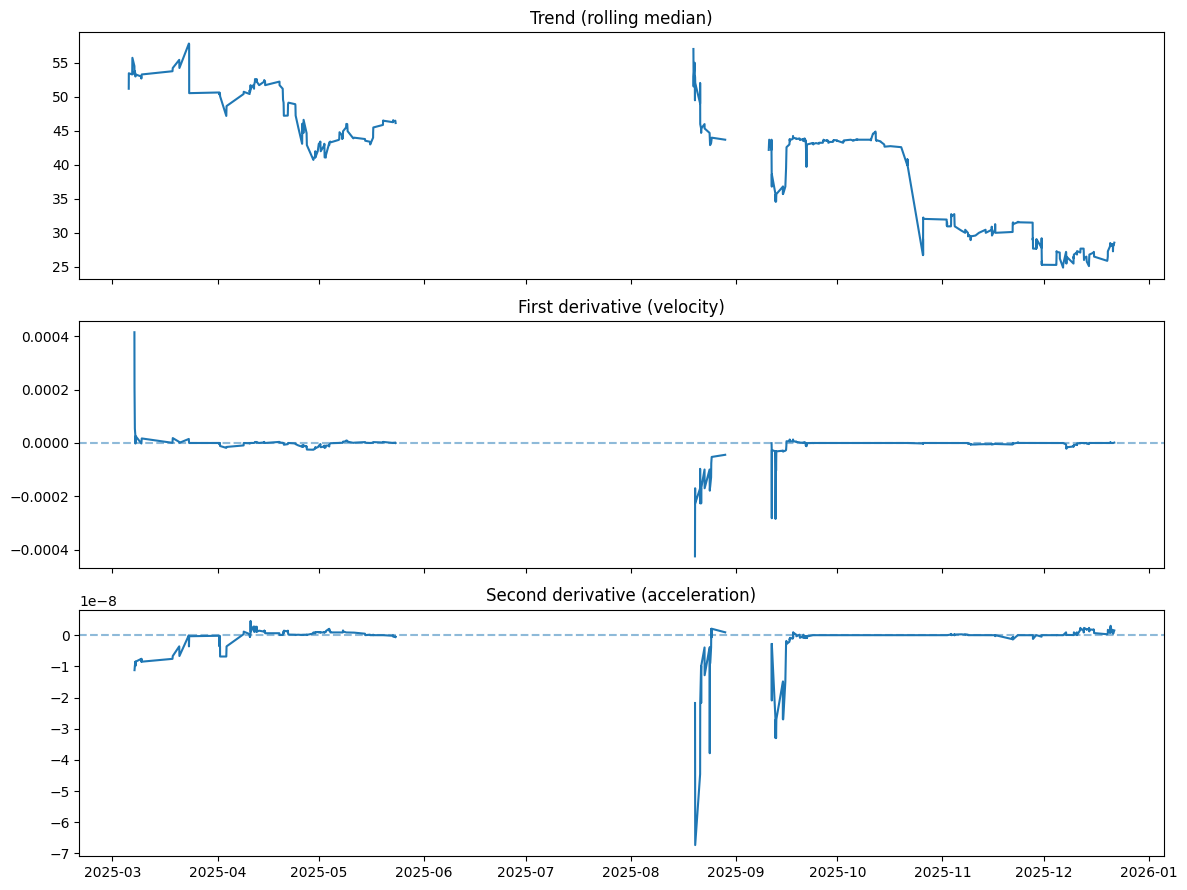

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# 0 — исходный тренд
axes[0].plot(trend.index, trend.values)
axes[0].set_title("Trend (rolling median)")

# 1 — первая производная
axes[1].plot(d1_s.index, d1_s.values)
axes[1].axhline(0, linestyle="--", alpha=0.5)
axes[1].set_title("First derivative (velocity)")

# 2 — вторая производная
axes[2].plot(d2_s.index, d2_s.values)
axes[2].axhline(0, linestyle="--", alpha=0.5)
axes[2].set_title("Second derivative (acceleration)")

plt.tight_layout()
plt.show()


In [24]:
print(d1_s.dropna().describe())
print(d2_s.dropna().describe())


count    567.000000
mean      -0.000009
std        0.000045
min       -0.000424
25%       -0.000004
50%        0.000000
75%        0.000000
max        0.000414
dtype: float64
count    5.630000e+02
mean    -1.316666e-09
std      6.680997e-09
min     -6.730373e-08
25%     -3.061372e-12
50%      0.000000e+00
75%      5.591263e-10
max      4.554776e-09
dtype: float64


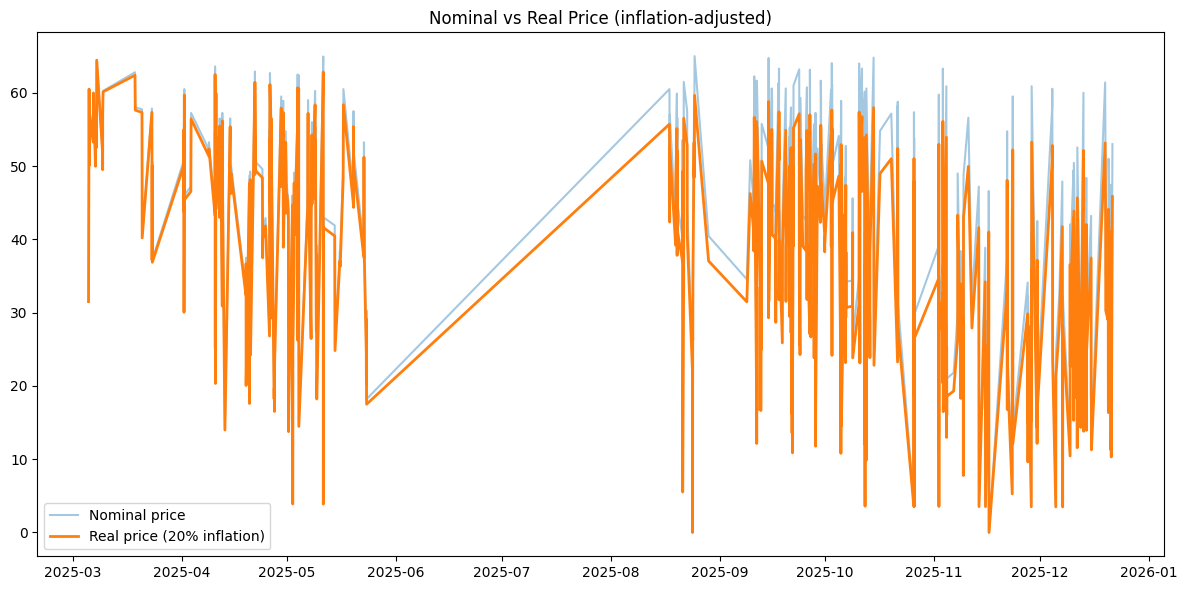

In [25]:
import numpy as np

start_date = df.index.min()
years = (df.index - start_date).days / 365.25


inflation_rate = 0.20
df["real_price"] = df["number"] / ((1 + inflation_rate) ** years)



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df.index, df["number"], alpha=0.4, label="Nominal price")
plt.plot(df.index, df["real_price"], linewidth=2, label="Real price (20% inflation)")

plt.legend()
plt.title("Nominal vs Real Price (inflation-adjusted)")
plt.tight_layout()
plt.show()


In [1]:
import price_getter

items_to_check = [
    ("WOOD", True),
    ("ORE", True),
    ('HIDE', True),
    ("FIBER", True),

    ("PLANKS", True),
    ("METALBAR", True),
    ("LEATHER", True),
    ("CLOTH", True)
]

In [2]:
import os
os.mkdir("dfs")

FileExistsError: [Errno 17] File exists: 'dfs'

In [2]:
def item_to_csv(raw_item: tuple):
    for i in range(4, 9):
        for ii in range(0, 5):
            item = price_getter.Item(raw_item[0], i, ii, raw_item[1])
            df = price_getter.get_prices(item)
            df.to_csv(os.path.join("dfs", f"{raw_item[0]}.csv"), mode="a")

In [ ]:
for i in items_to_check:
    item_to_csv(i)

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_prices_by_item(df: pd.DataFrame, *, location: str | None = None, quality: int | None = None):
    if df.empty:
        raise ValueError("df is empty")

    need = {"location","item_id","quality","timestamp","price_avg","item_count"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"missing columns: {sorted(miss)}")

    d = df.copy()
    
    d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")
    d["price_avg"] = pd.to_numeric(d["price_avg"], errors="coerce")

    d = d.dropna(subset=["timestamp", "price_avg", "item_id"])
    m = d["price_avg"].median()
    d = d[d["price_avg"] <= 3 * m]
    
    if location is not None:
        d = d[d["location"] == location]
    if quality is not None:
        d = d[d["quality"] == quality]

    if d.empty:
        raise ValueError("no rows after filters")

    d = d.sort_values("timestamp")

    fig, ax = plt.subplots(figsize=(23,6))
    for item_id, g in d.groupby("item_id", sort=False):
        gg = g.groupby("timestamp", as_index=False)["price_avg"].mean()
        ax.plot(gg["timestamp"], gg["price_avg"], marker="o", linewidth=0.9, label=item_id)

    ax.set_xlabel("date")
    ax.set_ylabel("price_avg")
    ax.set_title("price_avg over time by item_id")
    ax.grid(True)
    ax.legend(title="item_id", fontsize=9)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    return ax

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_price_pct_change(df: pd.DataFrame, *, location=None, quality=None):
    need = {"location","item_id","quality","timestamp","price_avg"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"missing columns: {sorted(miss)}")

    d = df.copy()
    d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")
    d["price_avg"] = pd.to_numeric(d["price_avg"], errors="coerce")

    d = d.dropna(subset=["timestamp", "price_avg", "item_id"])

    if location is not None:
        d = d[d["location"] == location]
    if quality is not None:
        d = d[d["quality"] == quality]

    if d.empty:
        raise ValueError("no data after filters")

    d = d.sort_values("timestamp")

    fig, ax = plt.subplots(figsize=(23, 6))

    for item_id, g in d.groupby("item_id", sort=False):

        g = g.sort_values("timestamp")

        gg = (
            g.groupby("timestamp", as_index=False)
             .agg(price_avg=("price_avg", "mean"))
        )

        gg["pct_change"] = gg["price_avg"].pct_change() * 100
        gg = gg.dropna(subset=["pct_change"])

        ax.plot(
            gg["timestamp"],
            gg["pct_change"],
            marker="o",
            linewidth=1.5,
            label=item_id,
        )

    ax.axhline(0)
    ax.set_xlabel("date")
    ax.set_ylabel("price change %")
    ax.set_title("price percentage change over time")
    ax.grid(True)
    ax.legend(title="item_id", fontsize=9)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    return ax


In [ ]:
for csv_file in os.listdir("dfs"):
    df = pd.read_csv(os.path.join("dfs", csv_file))
    plot_price_pct_change(df[df["item_id"] < "T6"])

In [32]:
for csv_file in os.listdir("dfs"):
    df = pd.read_csv(os.path.join("dfs", csv_file))
    plot_price_pct_change(df[df["item_id"] >= "T6"])

/tmp/ipykernel_186081/4135806870.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")


ValueError: no data after filters

гипотеза: цена на лоутир финальный продукт почти не меняется, так как львиная доля перекрафта происходит при максимальной эффективности (под бонусом и фокусом) и продается заказами

In [5]:
equipment = [
    "MAIN_HOLYSTAFF_AVALON",
    "2H_ICECRYSTAL_UNDEAD",
    "2H_INFERNOSTAFF_MORGANA",
    "2H_ARCANESTAFF",
    "MAIN_CURSEDSTAFF",
    "MAIN_NATURESTAFF_KEEPER",
    "2H_SHAPESHIFTER_AVALON",
    "2H_LONGBOW",
    "2H_QUARTERSTAFF_AVALON",
    "MAIN_RAPIER_MORGANA",
    "2H_CLAYMORE",
    "ARMOR_CLOTH_SET2",
    "ARMOR_LEATHER_SET3",
    "ARMOR_PLATE_SET3",
    "BAG"
]

In [6]:
import price_getter
import os

In [ ]:
def item_to_csv_2(raw_item: tuple, tier_range = range(4, 9), ench_range = range(0, 5)):
    for i in tier_range:
        for ii in ench_range:
            item = price_getter.Item(raw_item, i, ii)
            df = price_getter.get_prices(item)
            df.to_csv(os.path.join("dfs", f"{raw_item}.csv"), mode="a")

In [1]:
for eq in equipment:
    item_to_csv_2(eq)

NameError: name 'equipment' is not defined

In [ ]:
food = [
    ["MEAL_OMELETTE_AVALON", range(3, 8, 2), range(0, 4)],
    ["MEAL_OMELETTE", range(3, 8, 2), range(0, 4)],
    ["MEAL_OMELETTE_FISH", range(3, 8, 2), range(0, 4)],

    ["MEAL_STEW_AVALON", range(4, 9, 2), range(0, 4)],
    ["MEAL_STEW", range(4, 9, 2), range(0, 4)],
    ["MEAL_STEW_FISH", range(4, 9, 2), range(0, 4)],

    ["MEAL_SALAD", range(2, 7, 2), range(0, 4)],
    ["MEAL_SALAD_FISH", range(2, 7, 2), range(0, 4)],

    ["MEAL_SANDWICH_AVALON", range(4, 7, 2), range(0, 4)],
    ["MEAL_SANDWICH", range(4, 7, 2), range(0, 4)],
    ["MEAL_SANDWICH_FISH", range(4, 7, 2), range(0, 4)],

    ["MEAL_PIE_FISH", range(3, 8, 2), range(0, 4)],
    ["MEAL_PIE", range(3, 8, 2), range(0, 4)]
]

for f in food:
    item_to_csv_2(f[0], f[1], f[2])

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_price_first_derivative(df: pd.DataFrame, *, location=None, quality=None):
    need = {"location","item_id","quality","timestamp","price_avg"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"missing columns: {sorted(miss)}")

    d = df.copy()
    d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")
    d["price_avg"] = pd.to_numeric(d["price_avg"], errors="coerce")

    m = df["price_avg"].median()
    d = d.dropna(subset=["timestamp", "price_avg", "item_id"])
    d = df[df["price_avg"] <= 3 * m]

    if location is not None:
        d = d[d["location"] == location]
    if quality is not None:
        d = d[d["quality"] == quality]

    if d.empty:
        raise ValueError("no data after filters")

    d = d.sort_values("timestamp")

    fig, ax = plt.subplots(figsize=(23,6))

    for item_id, g in d.groupby("item_id", sort=False):
        g = (
            g.groupby("timestamp", as_index=False)
             .agg(price_avg=("price_avg", "mean"))
             .sort_values("timestamp")
        )

        dt = g["timestamp"].diff().dt.total_seconds() / 86400.0
        dp = g["price_avg"].diff()

        g["d_price_dt"] = dp / dt
        g = g.dropna(subset=["d_price_dt"])

        ax.plot(
            g["timestamp"],
            g["d_price_dt"],
            marker="o",
            linewidth=1.5,
            label=item_id,
        )

    ax.axhline(0)
    ax.set_xlabel("date")
    ax.set_ylabel("d(price)/dt (per day)")
    ax.set_title("first derivative of price over time")
    ax.grid(True)
    ax.legend(title="item_id", fontsize=9)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    return ax


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_week1_vs_last_week_change(df: pd.DataFrame, *, location=None, quality=None, relative: bool = False):
    need = {"location","item_id","quality","timestamp","price_avg"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"missing columns: {sorted(miss)}")

    d = df.copy()
    d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")
    d["price_avg"] = pd.to_numeric(d["price_avg"], errors="coerce")
    m = df["price_avg"].median()
    d = d.dropna(subset=["timestamp", "price_avg", "item_id"])
    d = df[df["price_avg"] <= 3 * m]

    if location is not None:
        d = d[d["location"] == location]
    if quality is not None:
        d = d[d["quality"] == quality]

    if d.empty:
        raise ValueError("no data after filters")

    t0 = d["timestamp"].min().floor("D")
    t1 = d["timestamp"].max().floor("D")

    first = d[(d["timestamp"] >= t0) & (d["timestamp"] < t0 + pd.Timedelta(days=7))]
    last  = d[(d["timestamp"] >  t1 - pd.Timedelta(days=7)) & (d["timestamp"] <= t1)]

    first_mean = first.groupby("item_id")["price_avg"].mean()
    last_mean  = last.groupby("item_id")["price_avg"].mean()

    out = (
        pd.concat(
            [first_mean.rename("first_week_avg"),
             last_mean.rename("last_week_avg")],
            axis=1
        )
        .dropna()
        .sort_index()
    )

    if out.empty:
        raise ValueError("no item_id has data in both first and last week windows")

    if relative:
        out["change"] = (out["last_week_avg"] / out["first_week_avg"] - 1.0) * 100.0
        ylabel = "change (%)"
        title = "price change: first week vs last week (%)"
    else:
        out["change"] = out["last_week_avg"] - out["first_week_avg"]
        ylabel = "change (absolute)"
        title = "price change: first week vs last week (absolute)"

    fig, ax = plt.subplots(figsize=(max(8, 0.35 * len(out)), 5))
    ax.bar(out.index.astype(str), out["change"])
    ax.axhline(0)
    ax.set_xlabel("item_id")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, axis="y")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

    return out


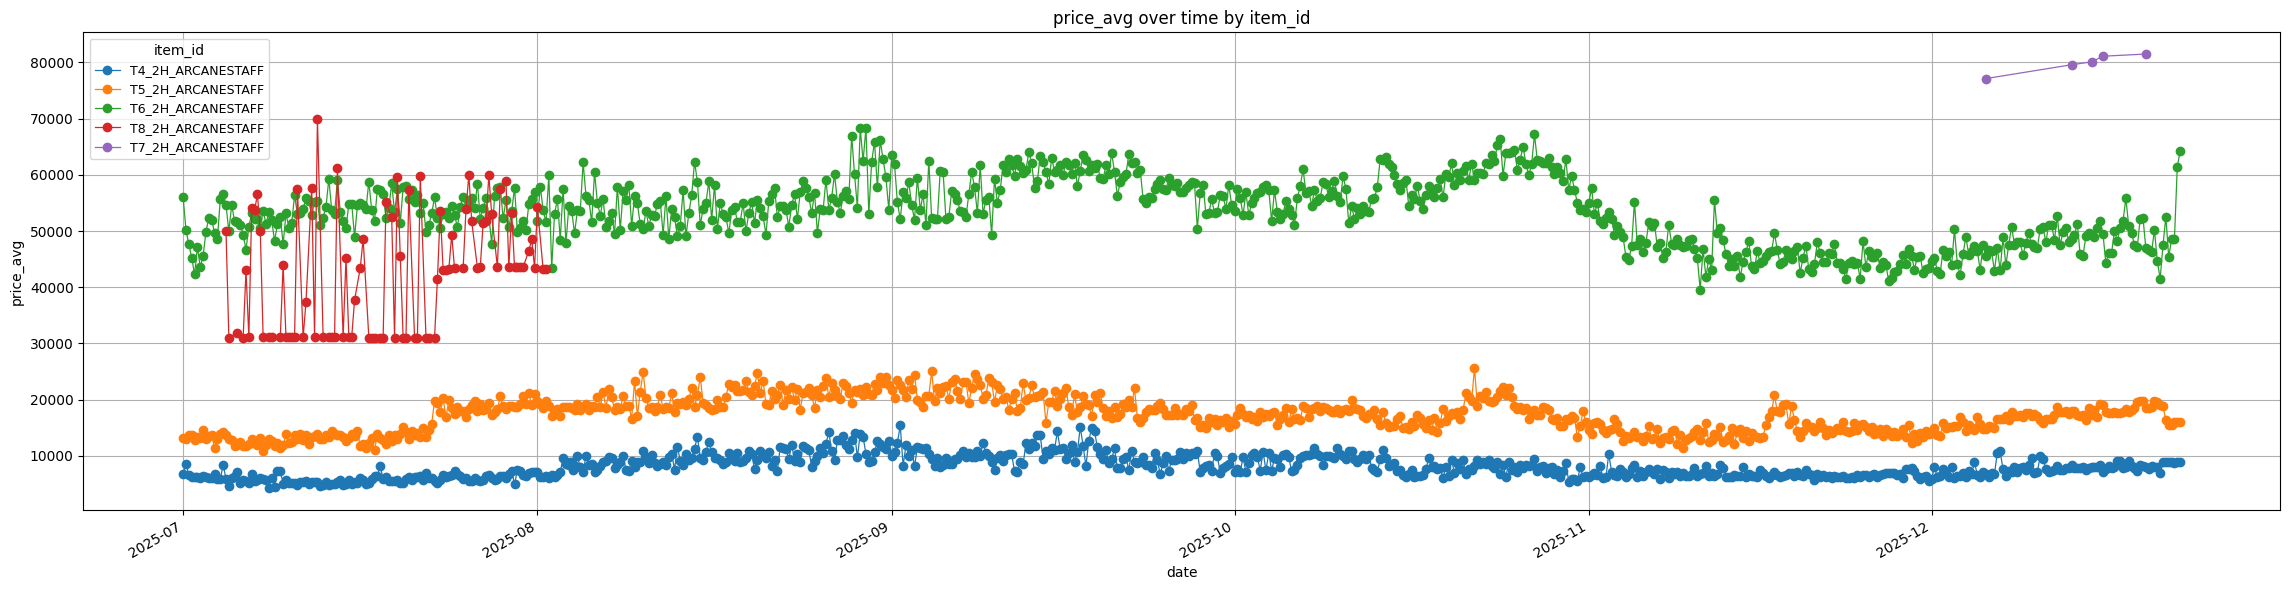

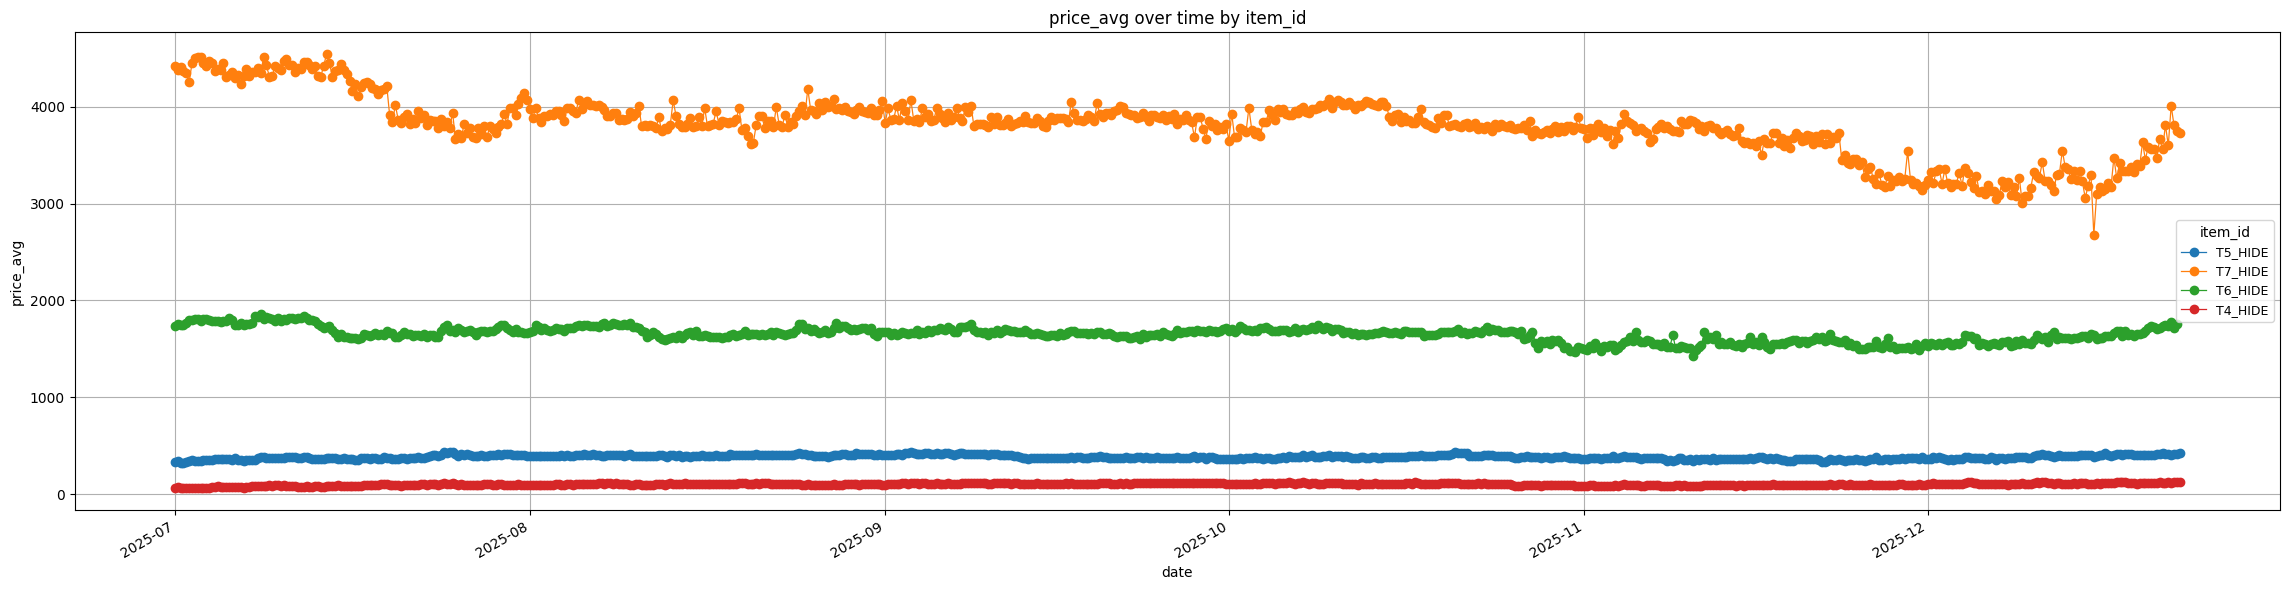

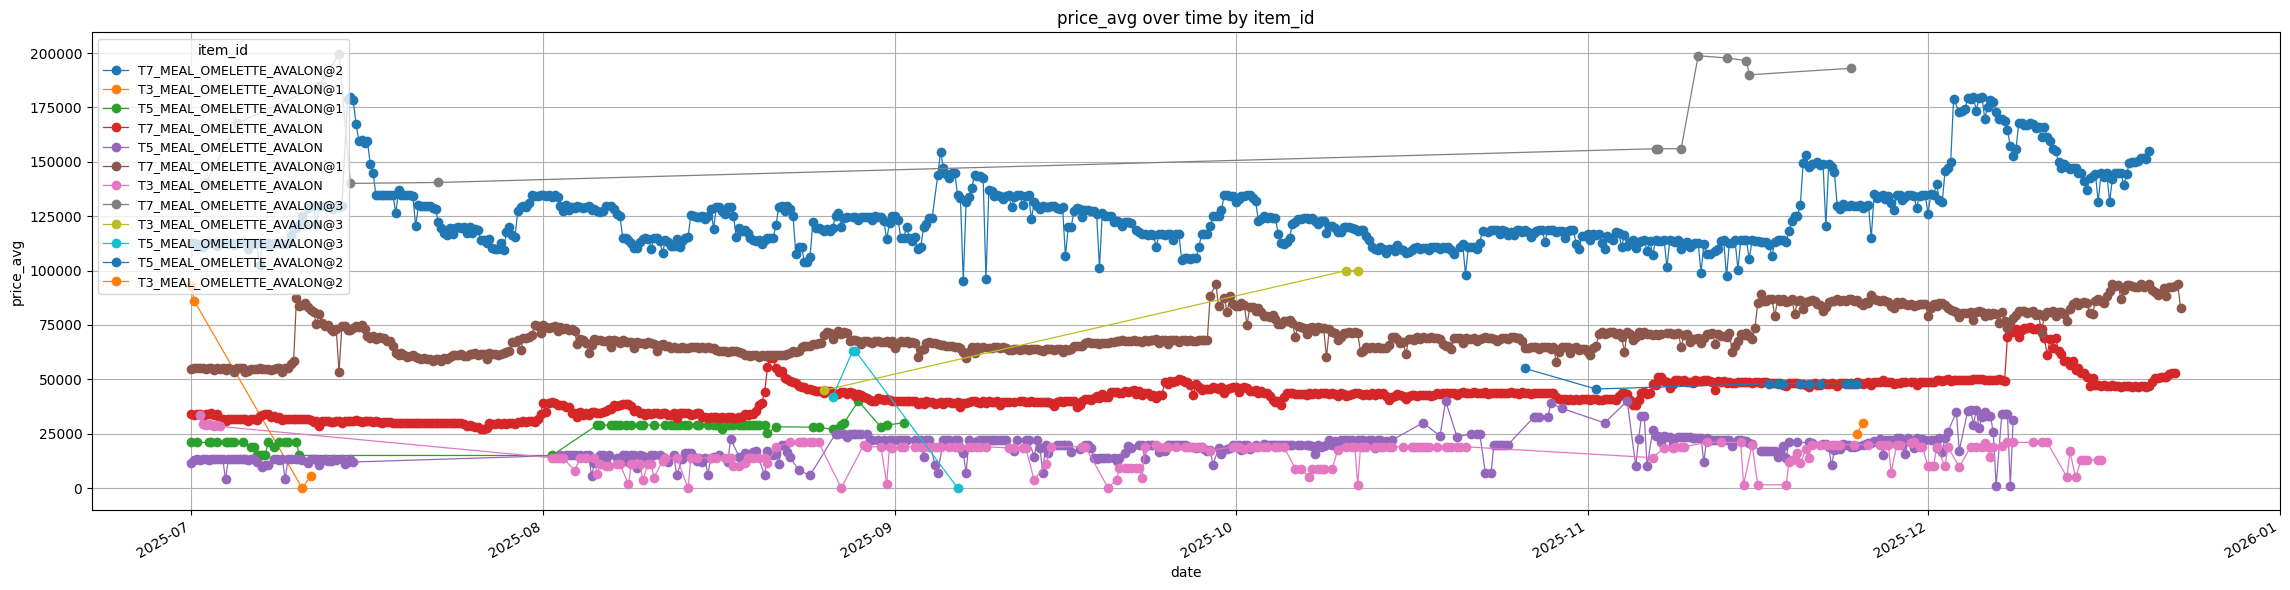

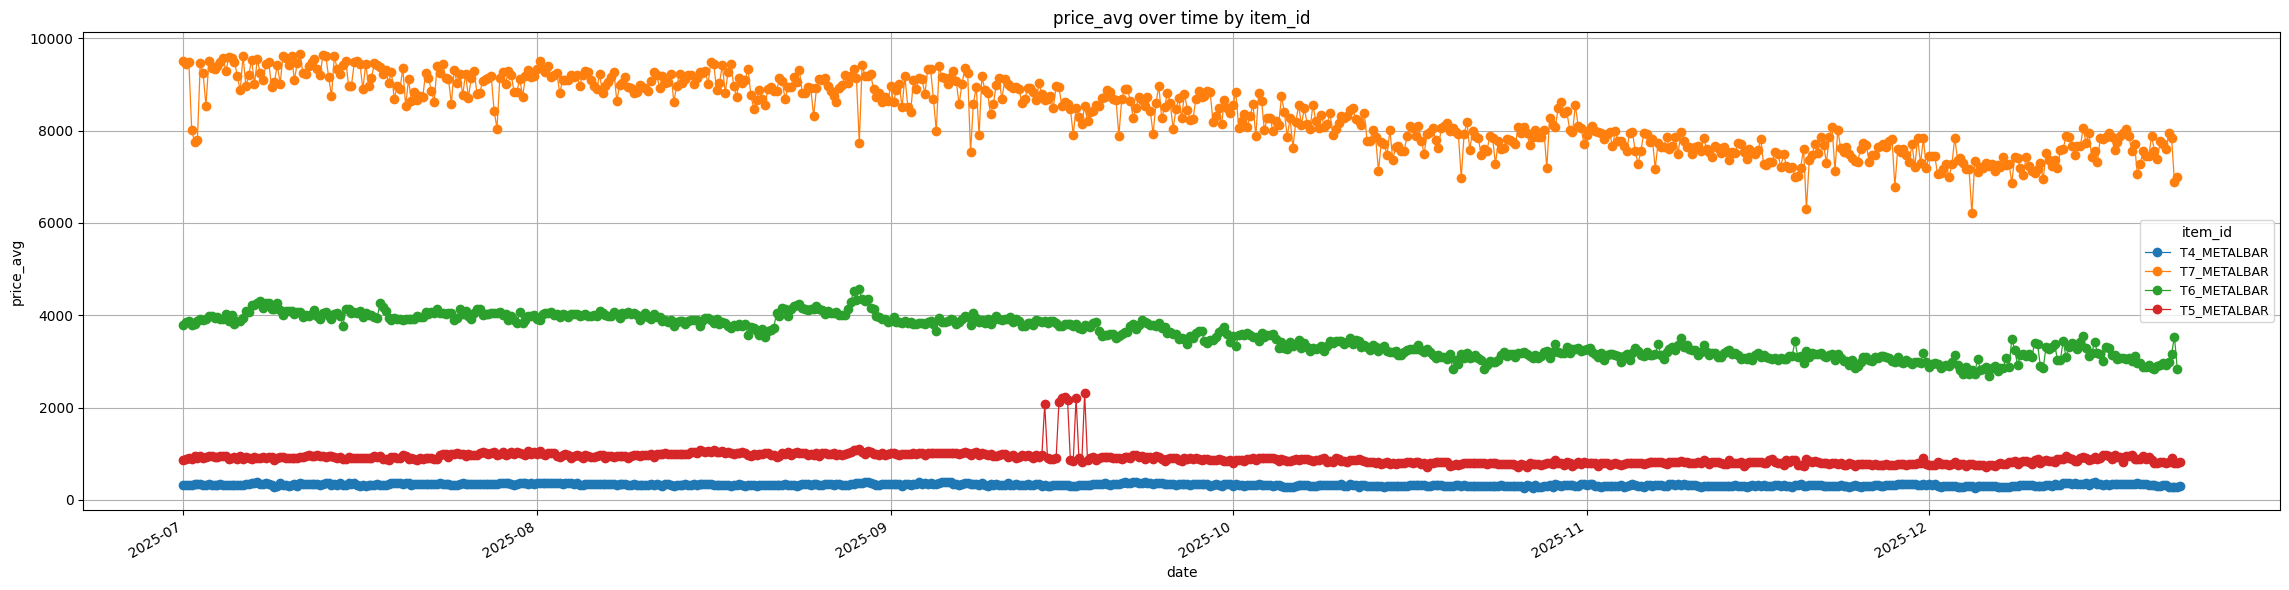

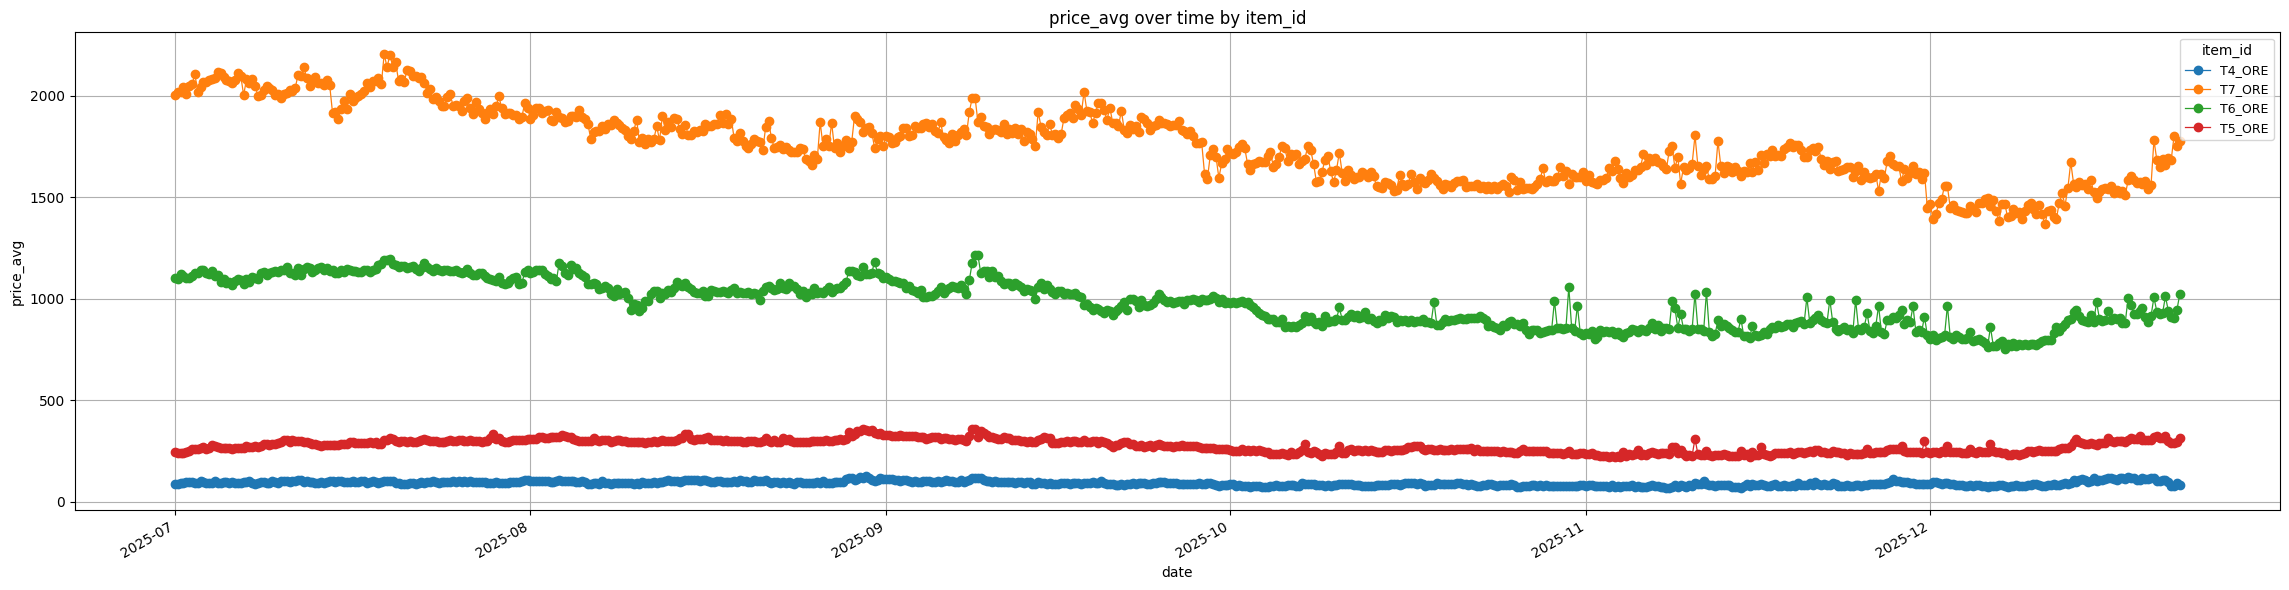

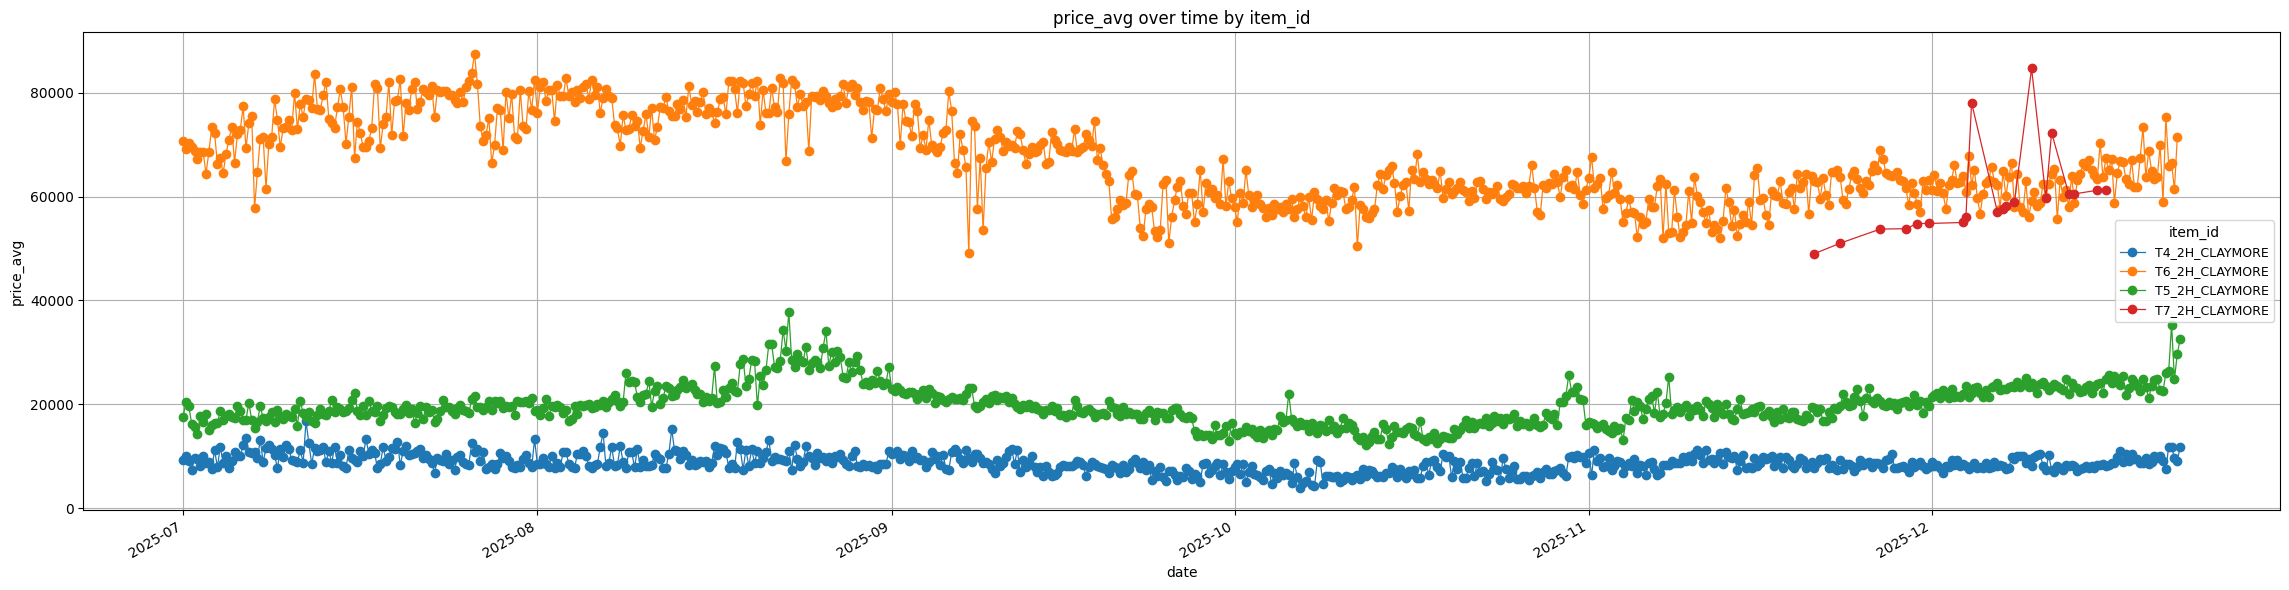

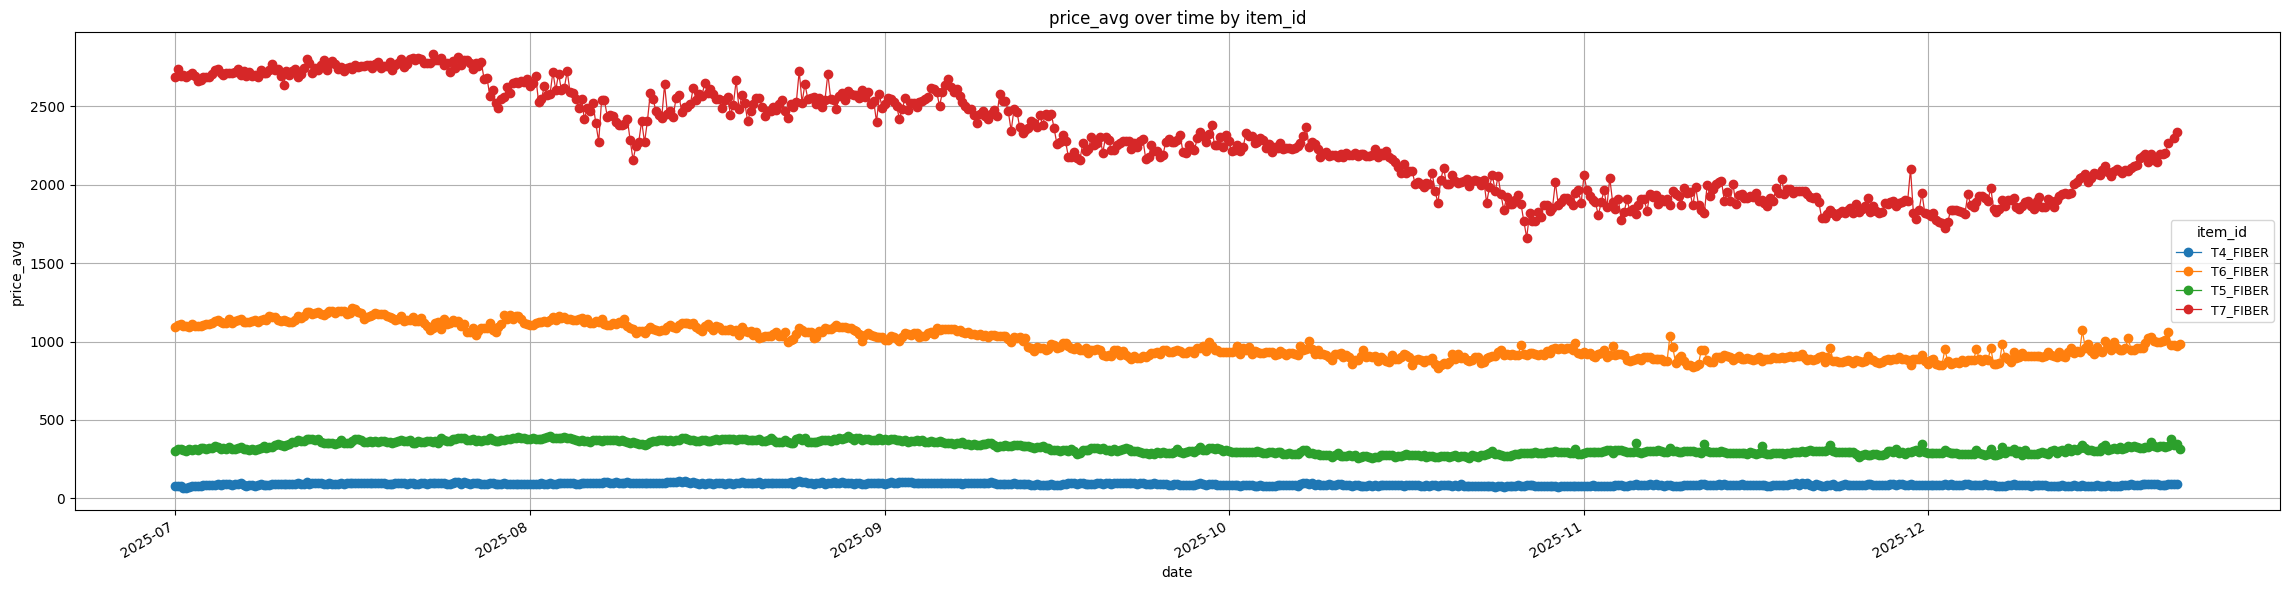

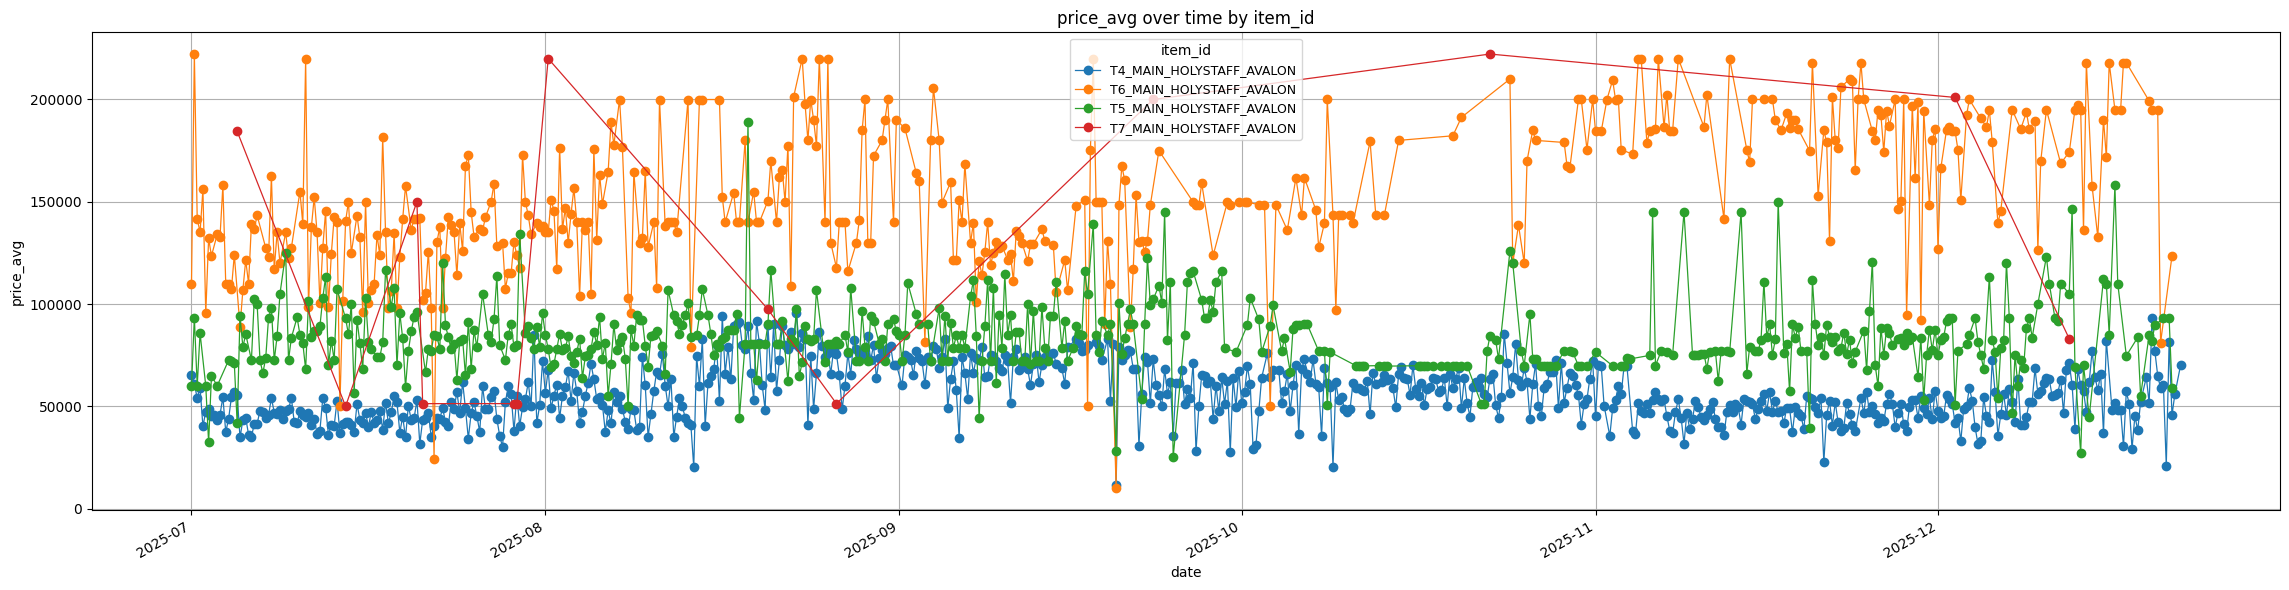

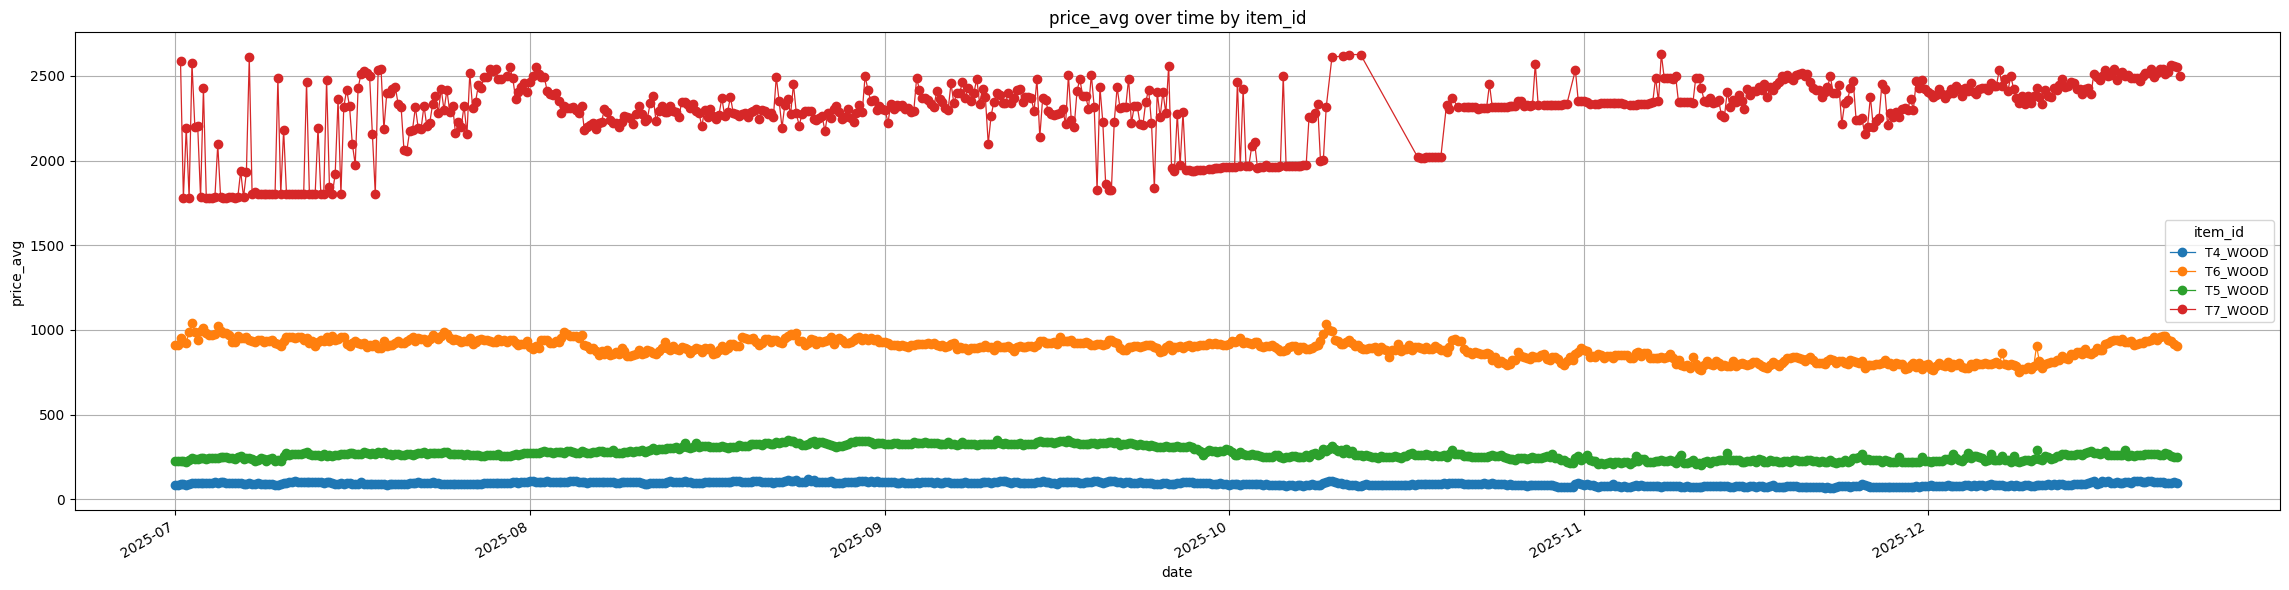

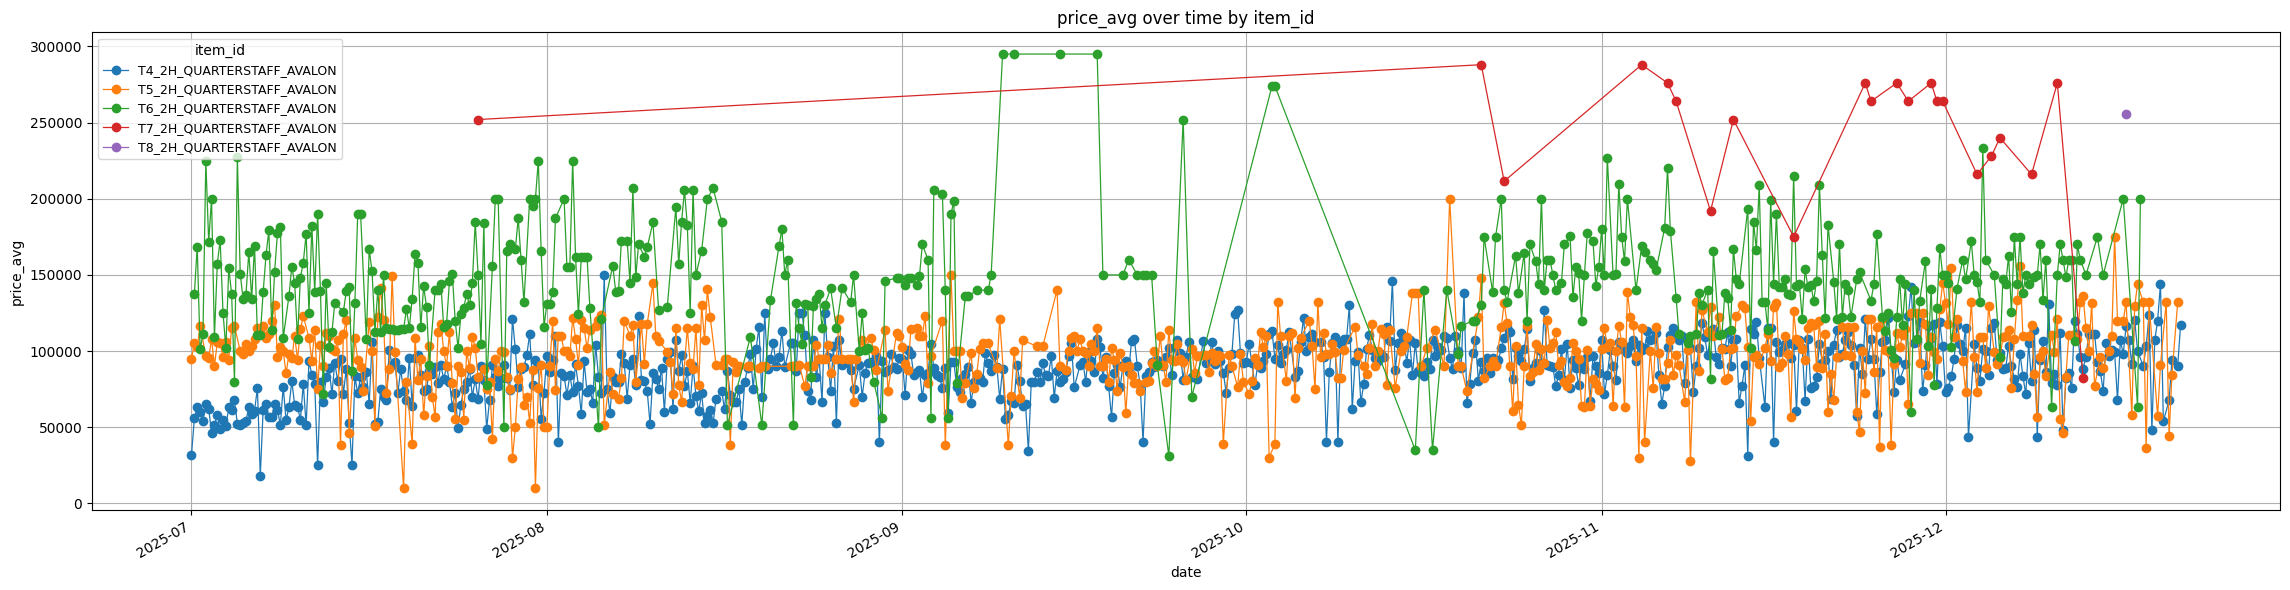

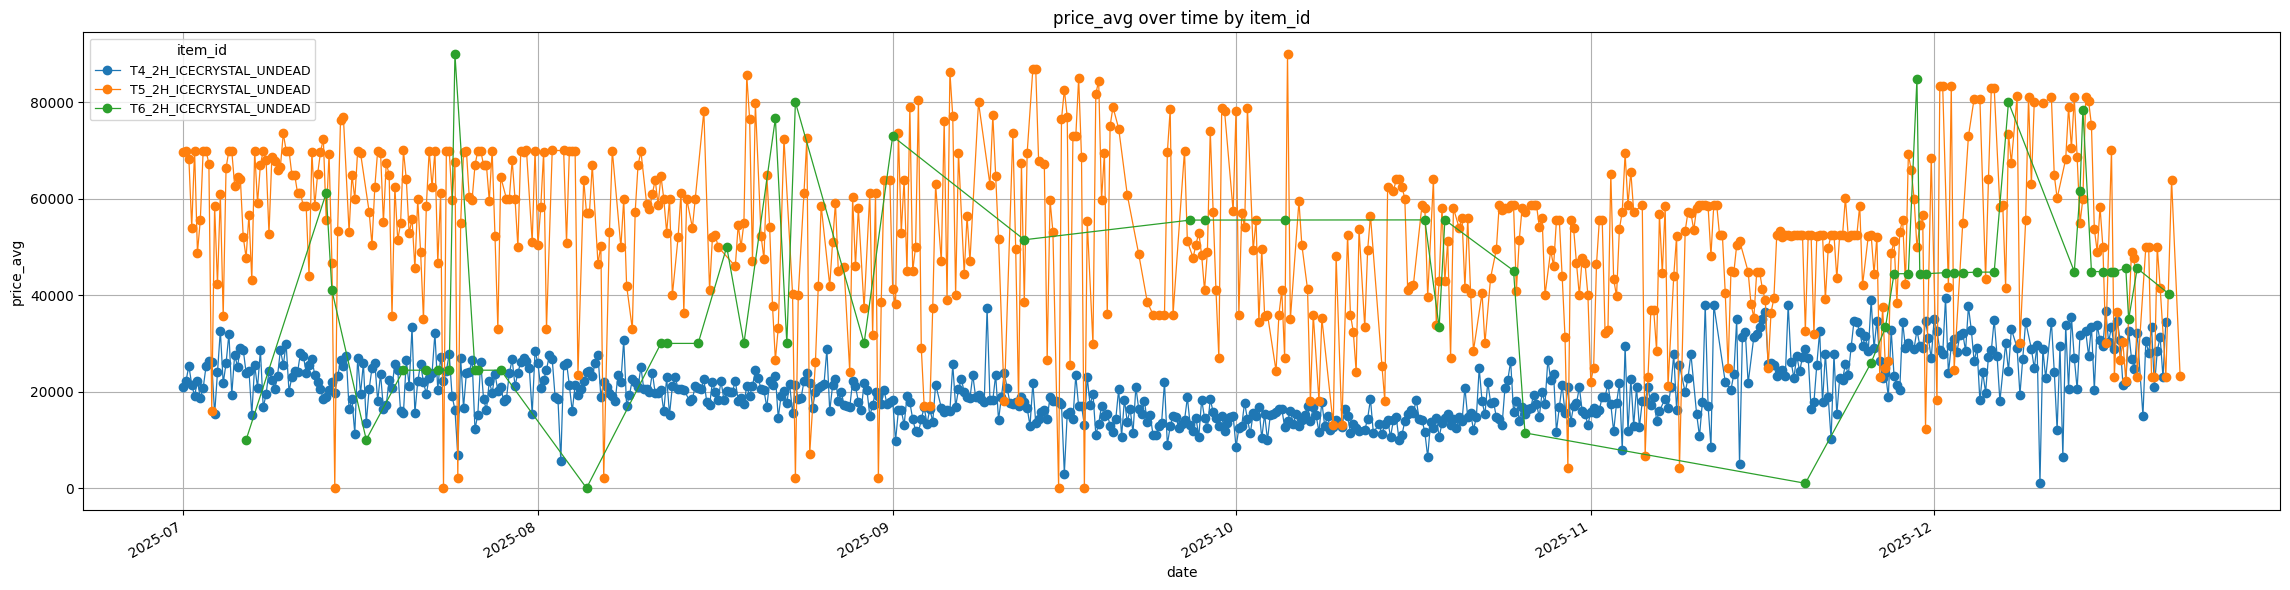

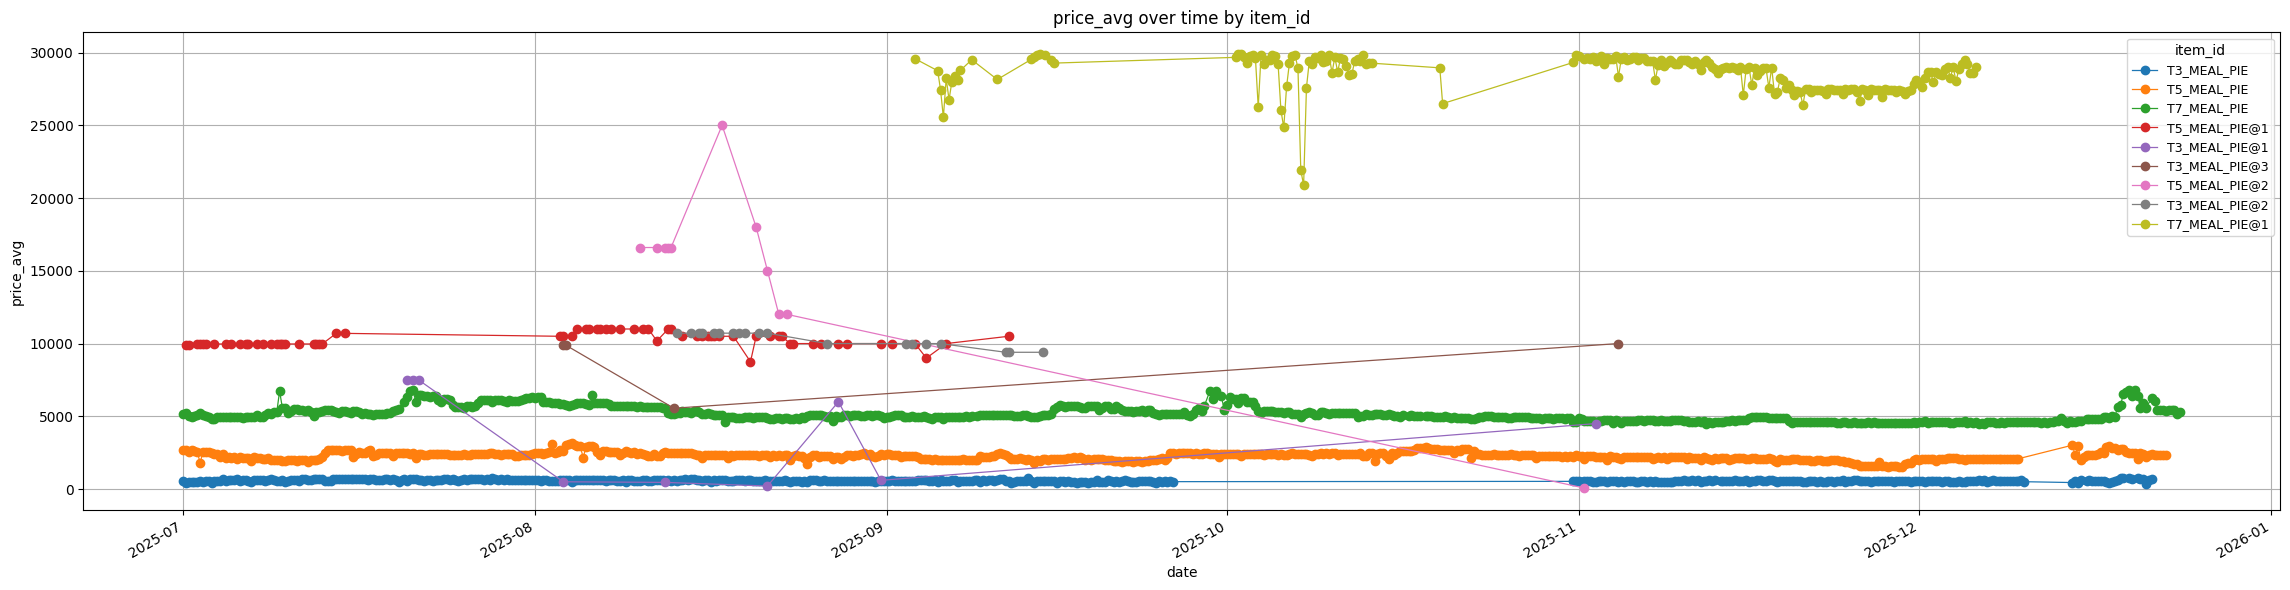

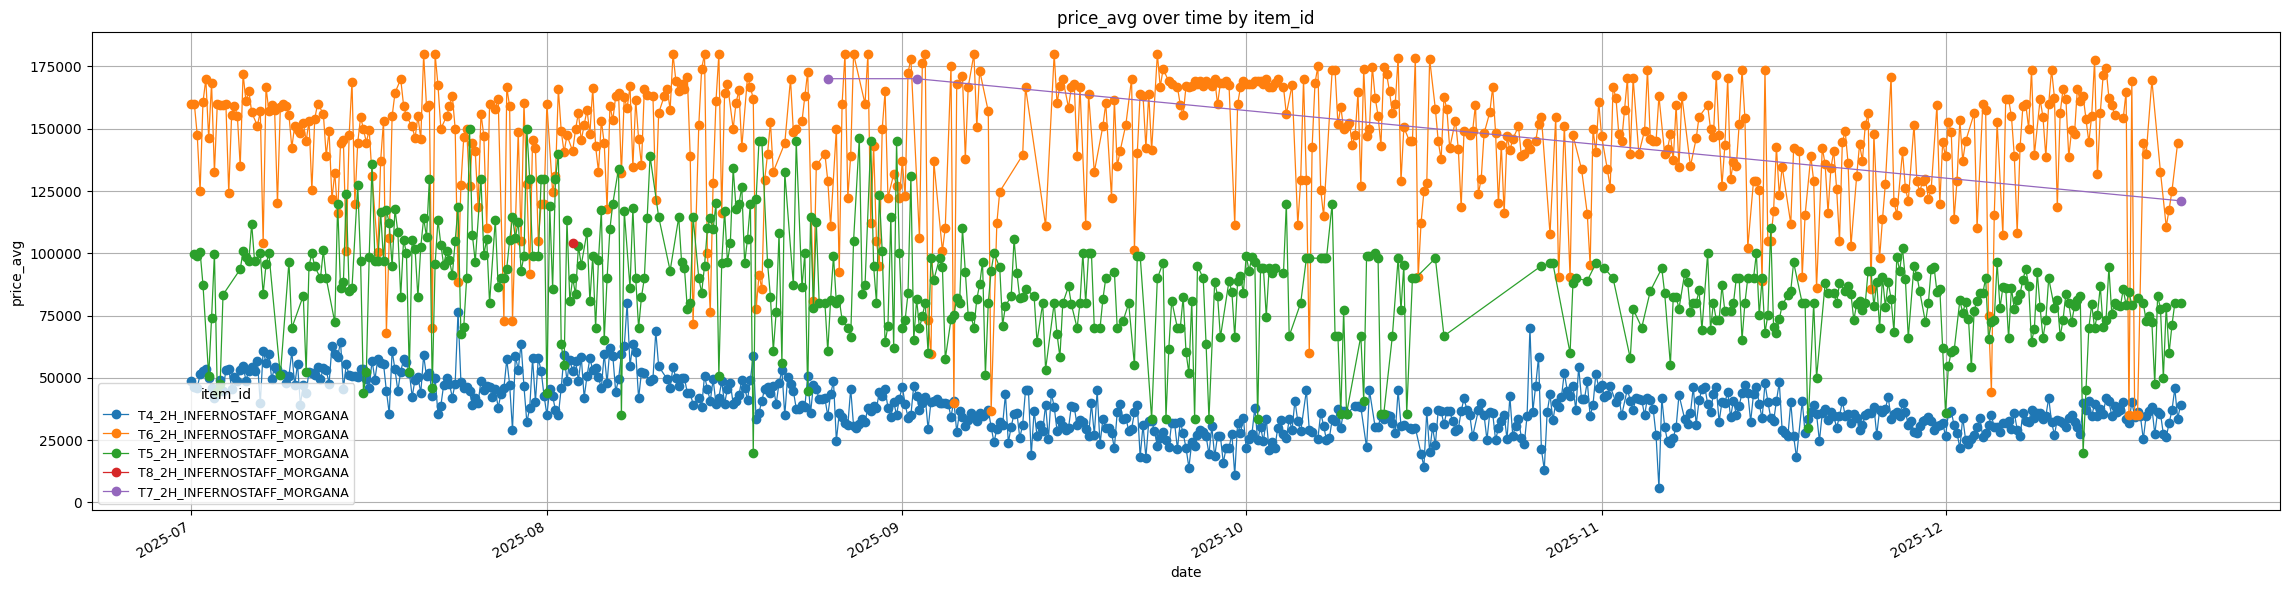

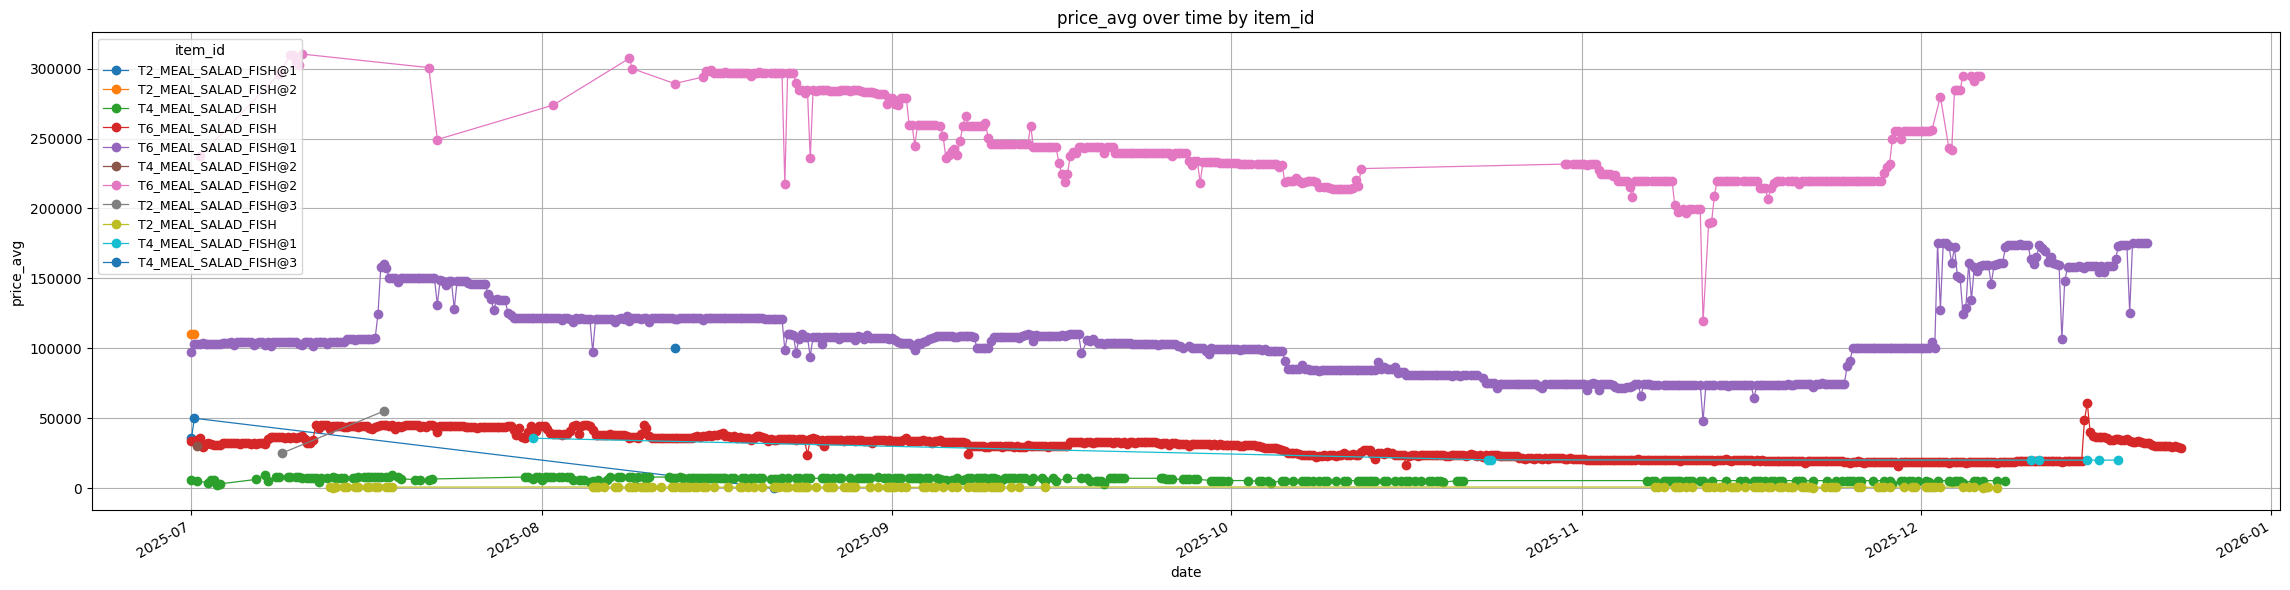

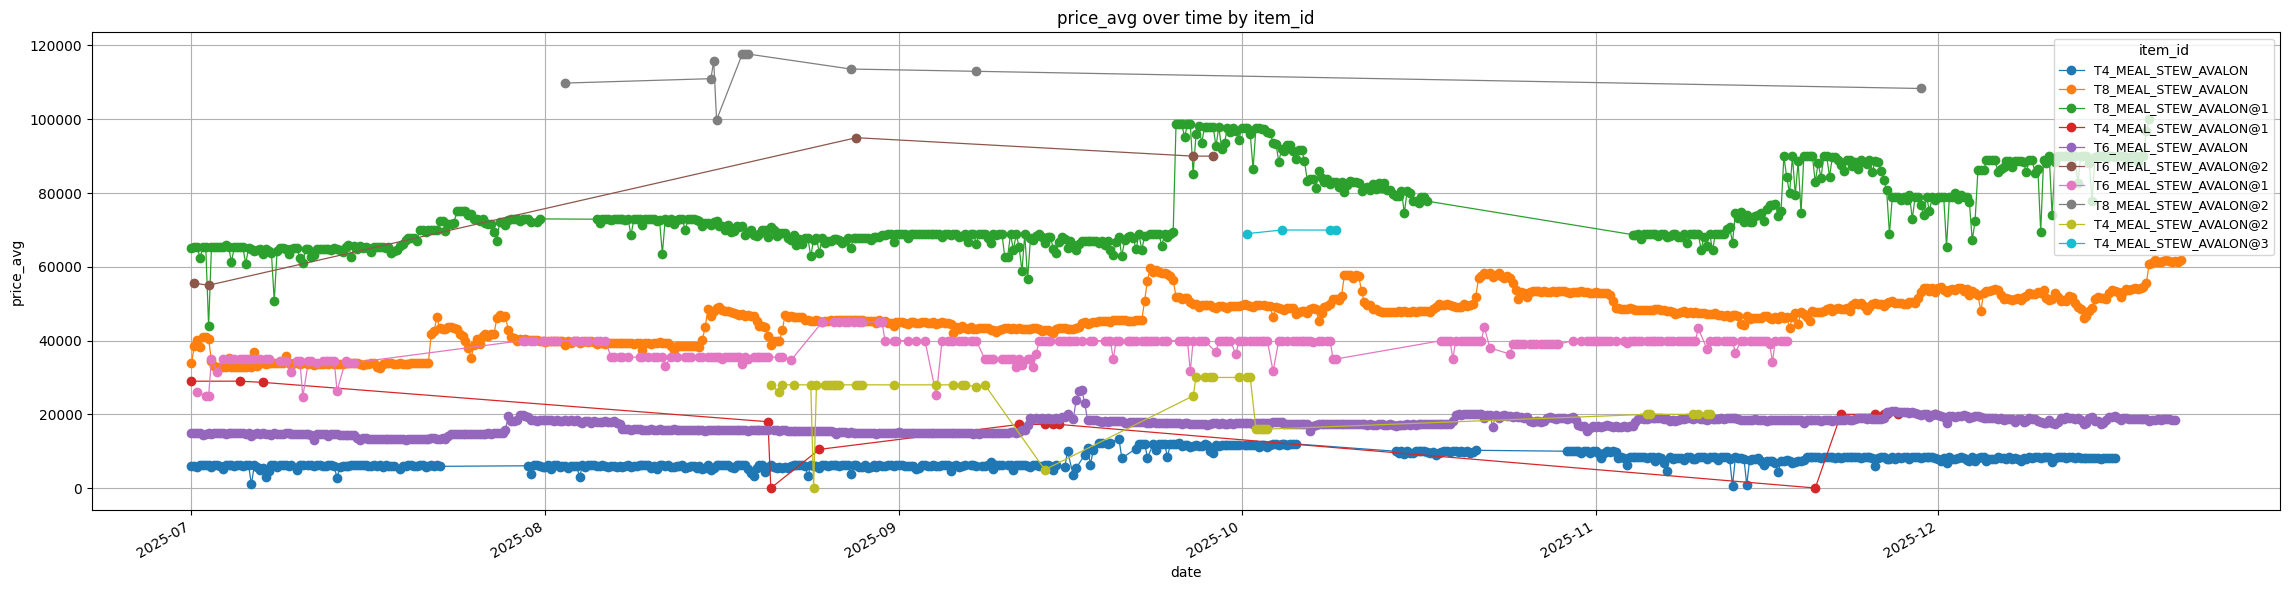

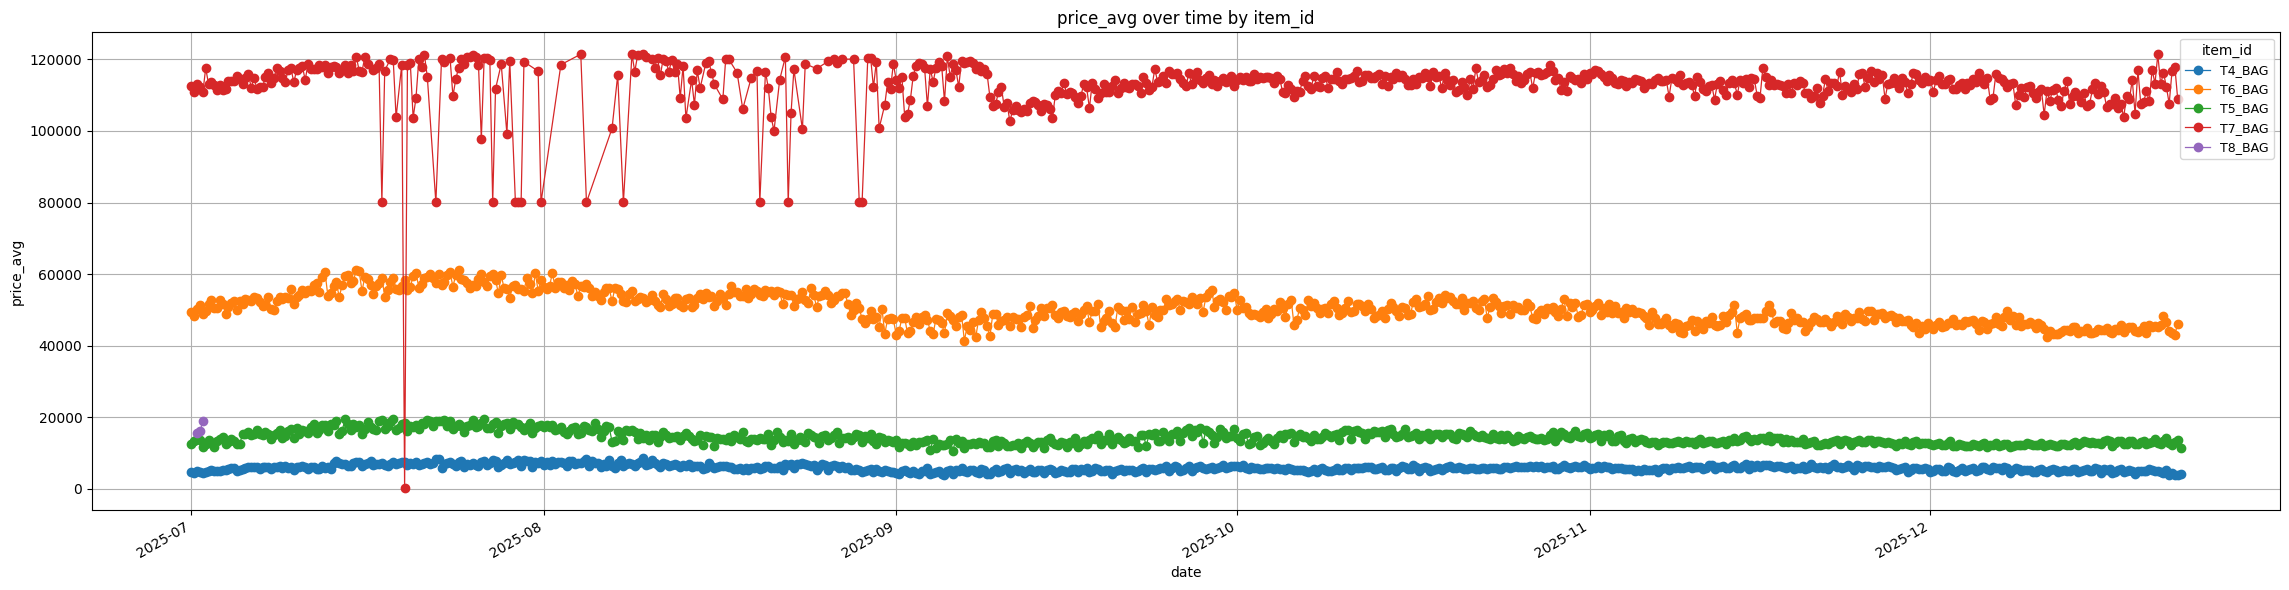

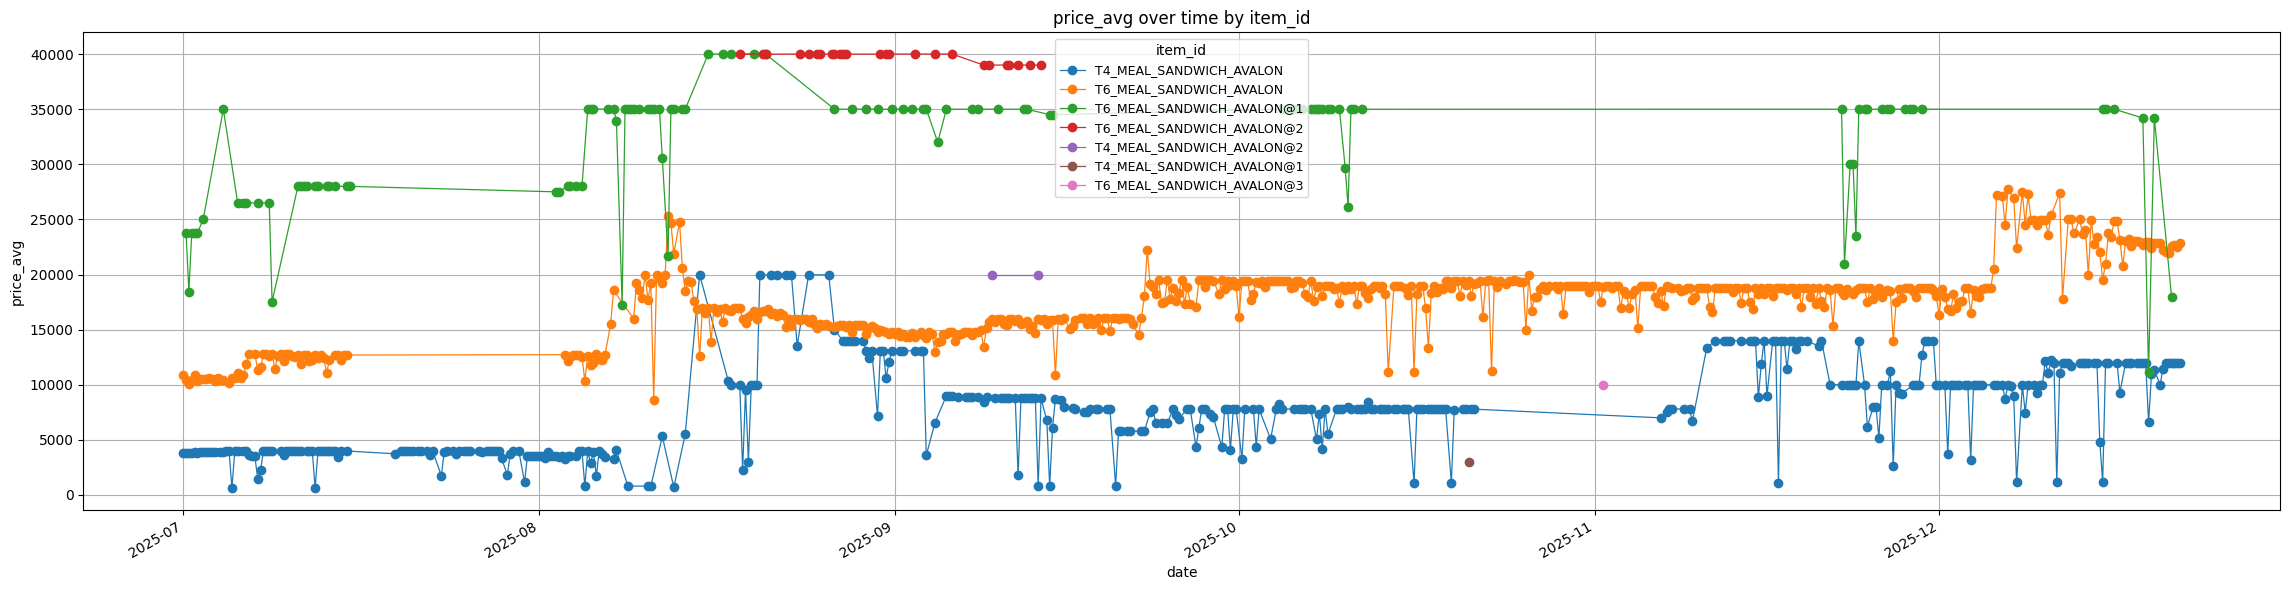

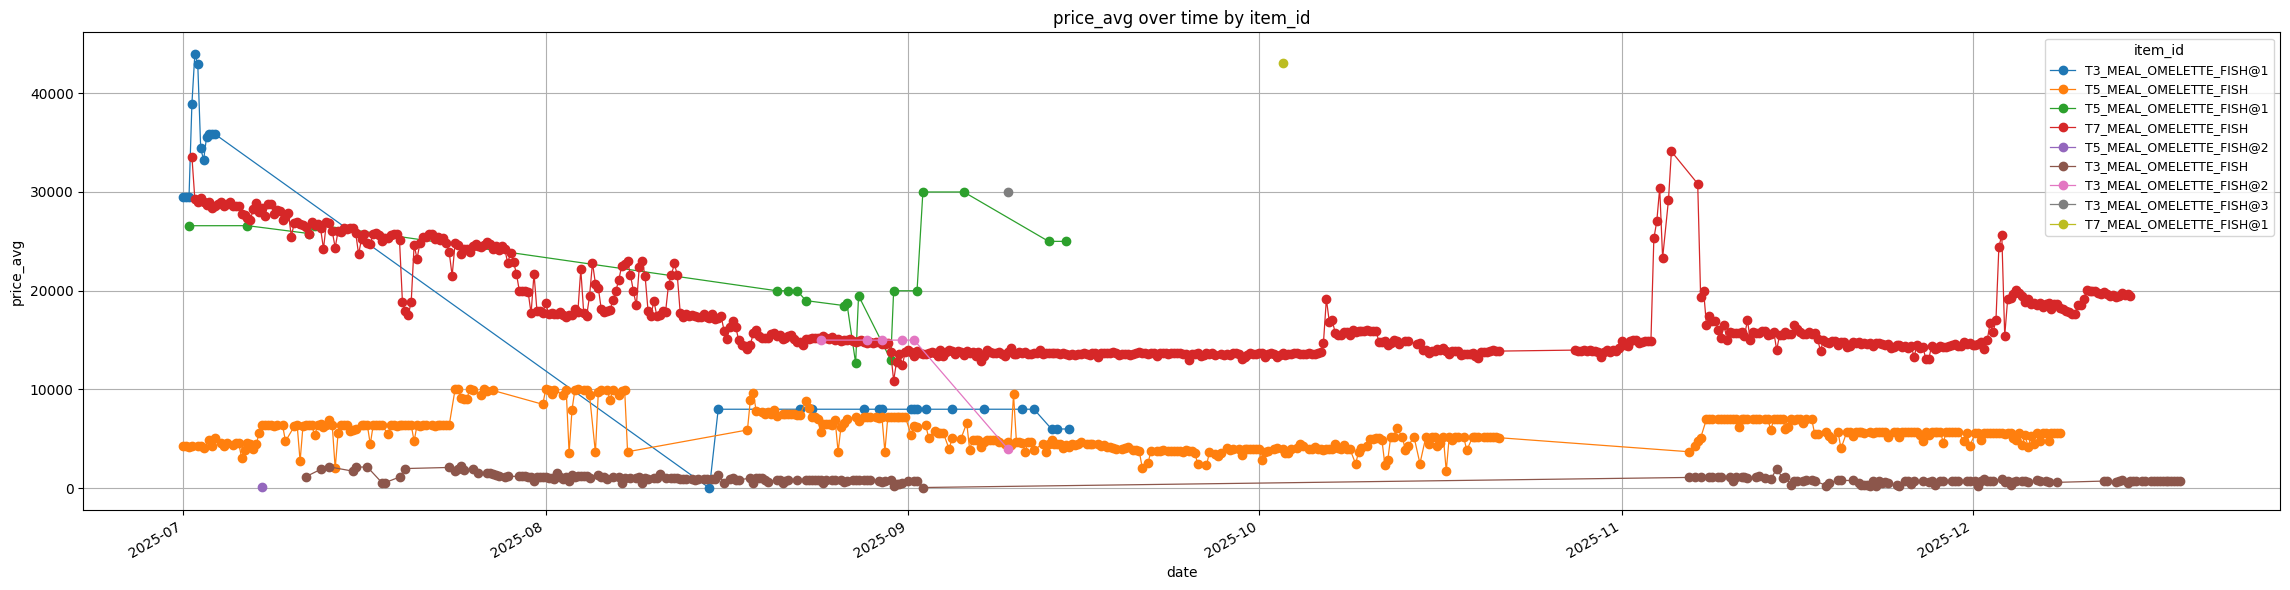

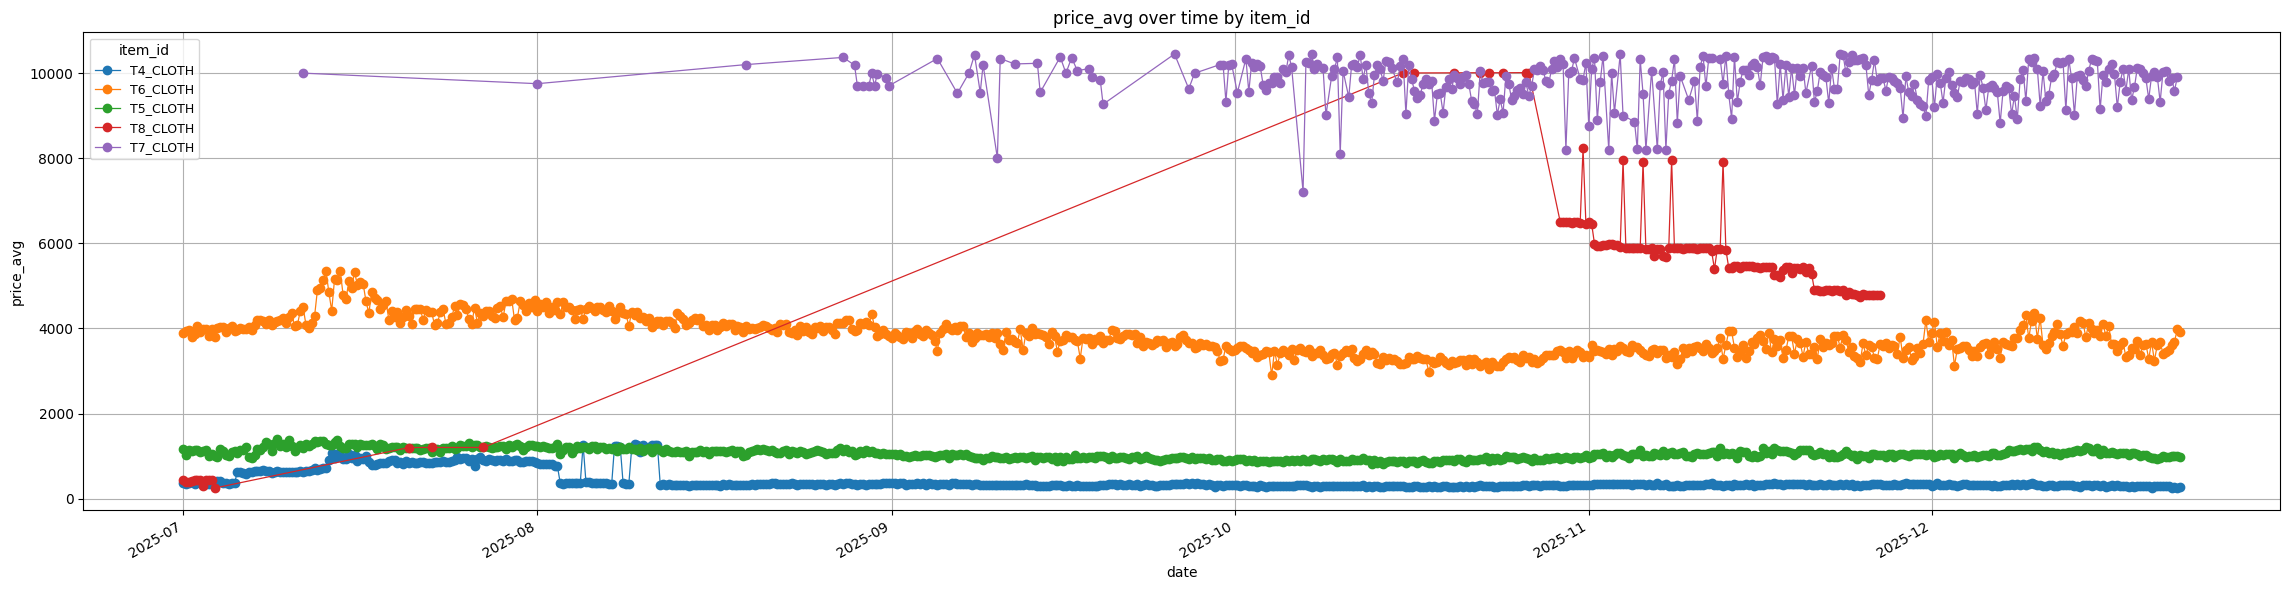

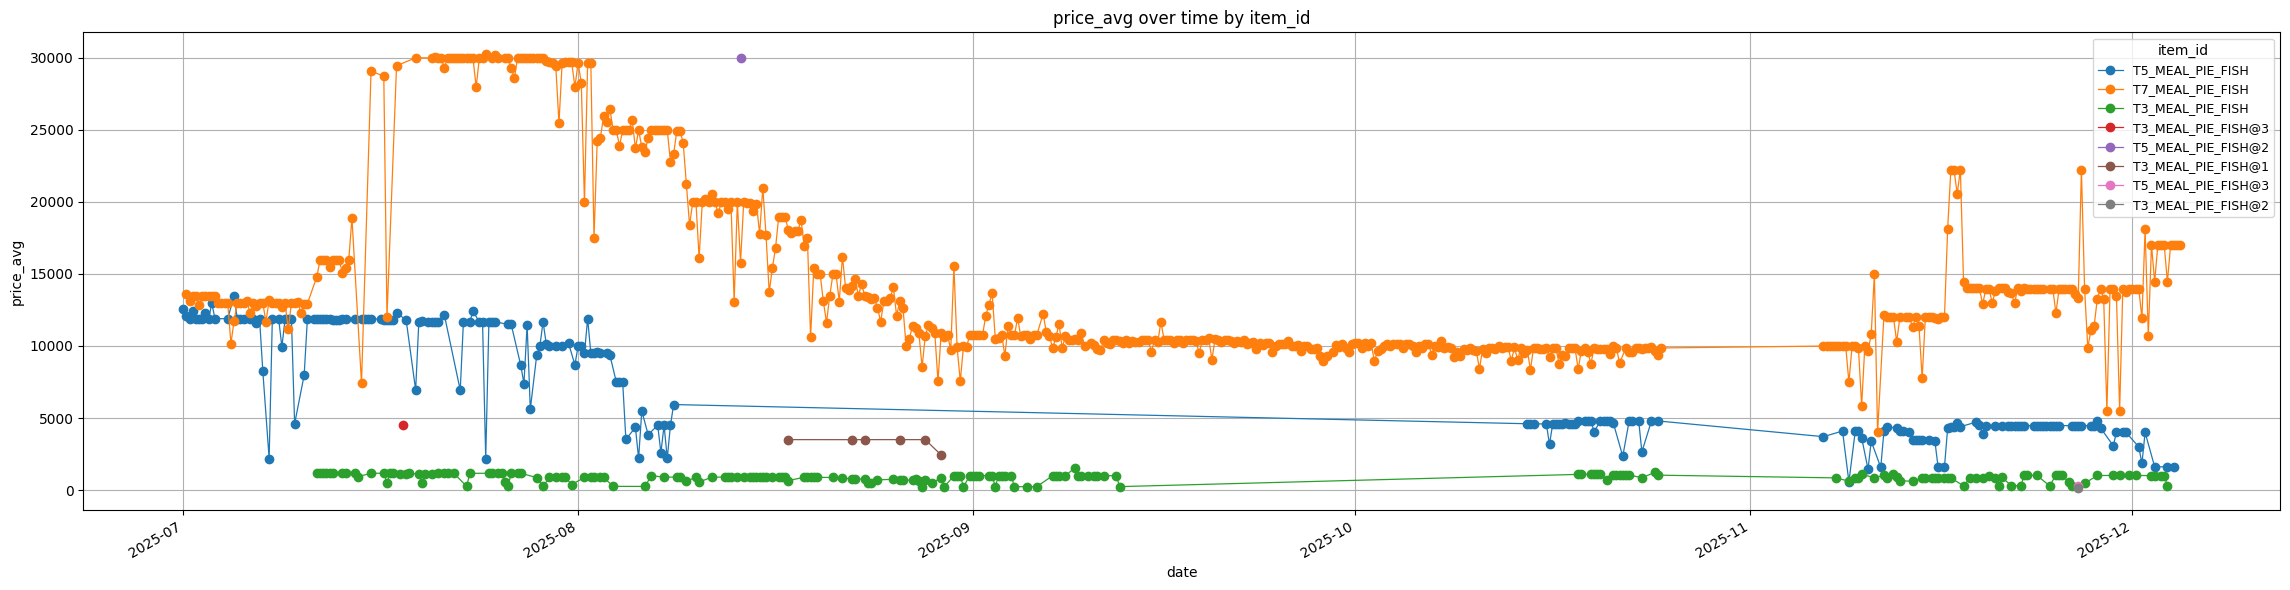

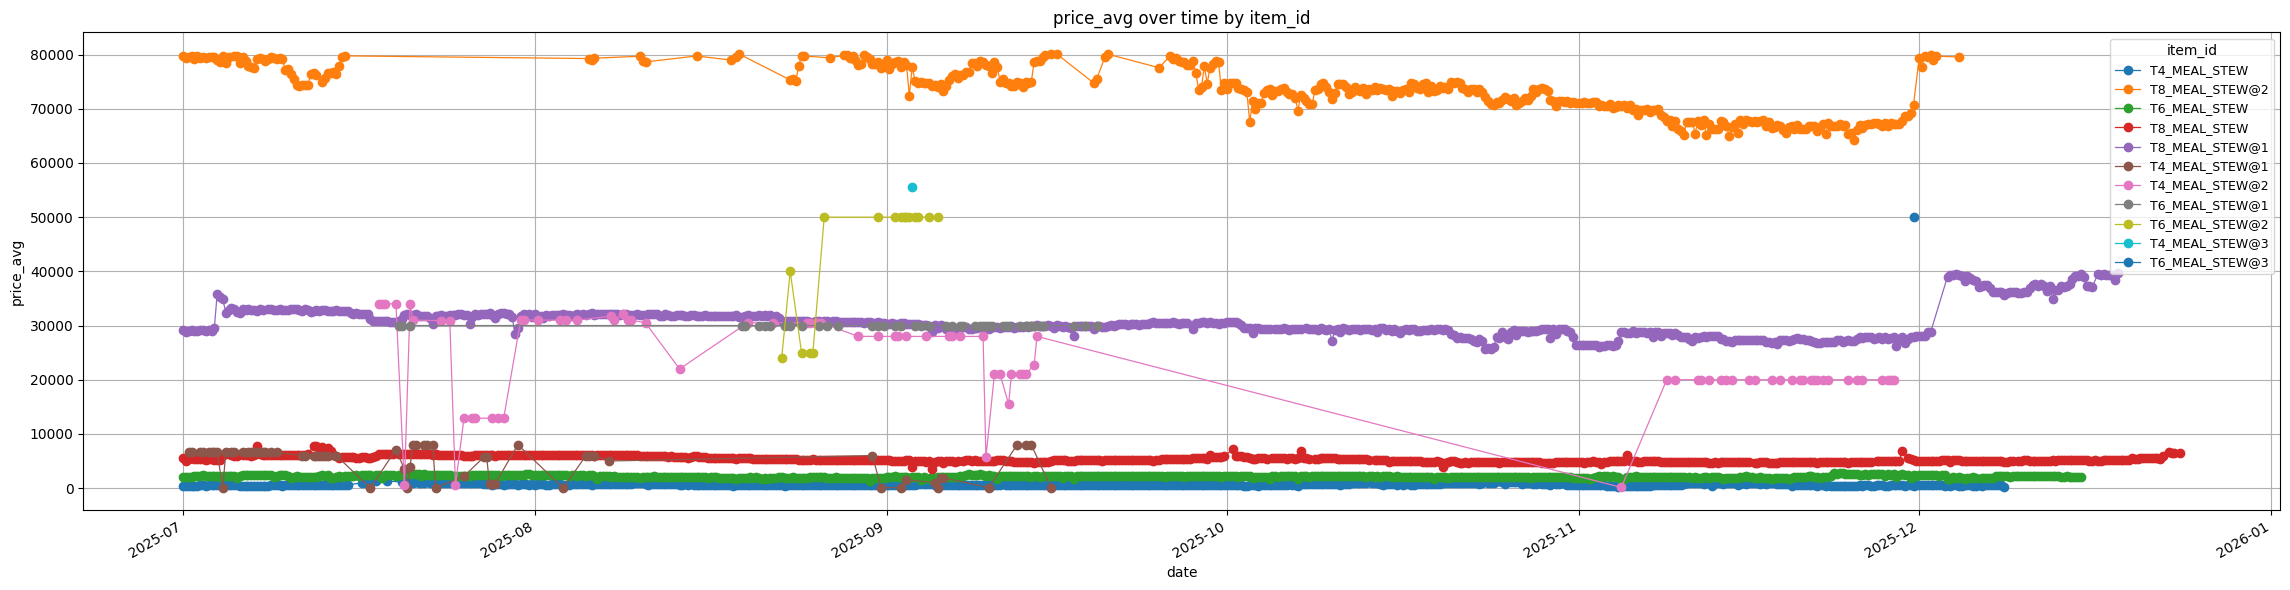

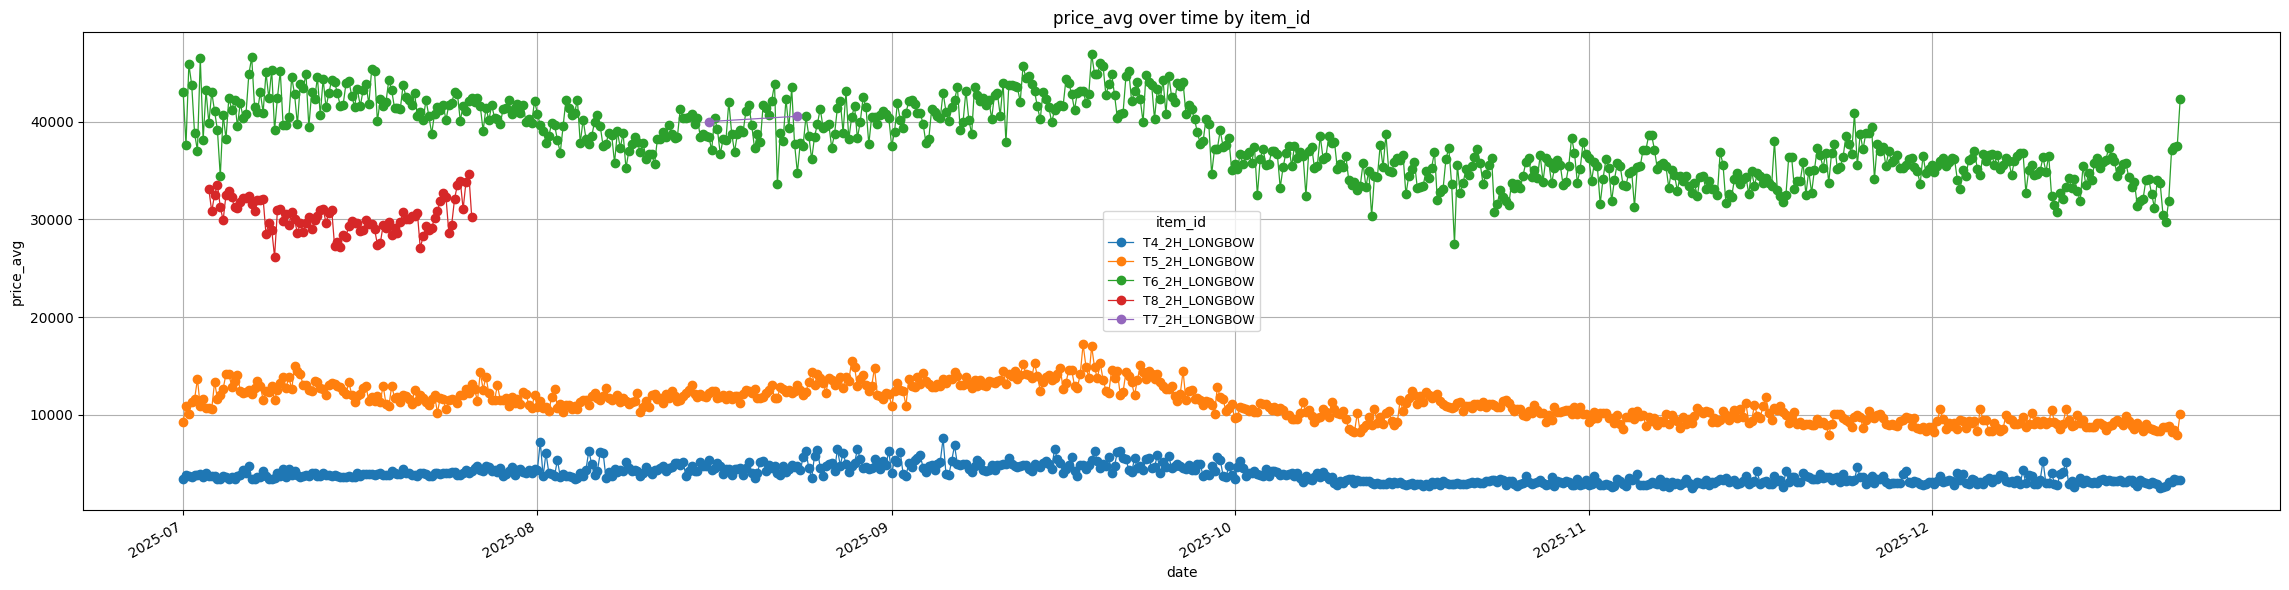

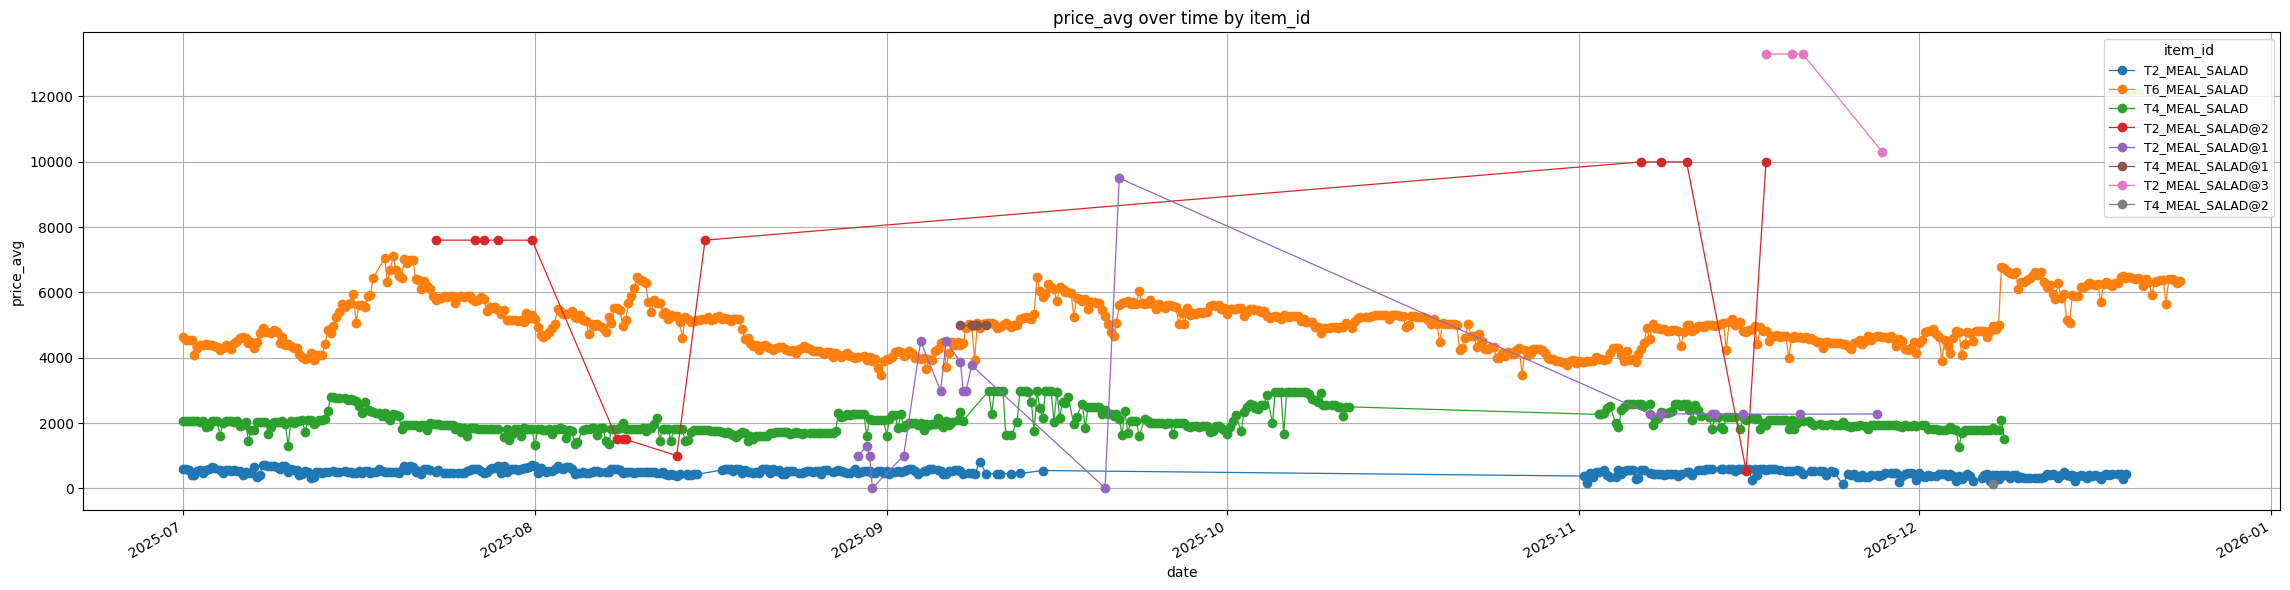

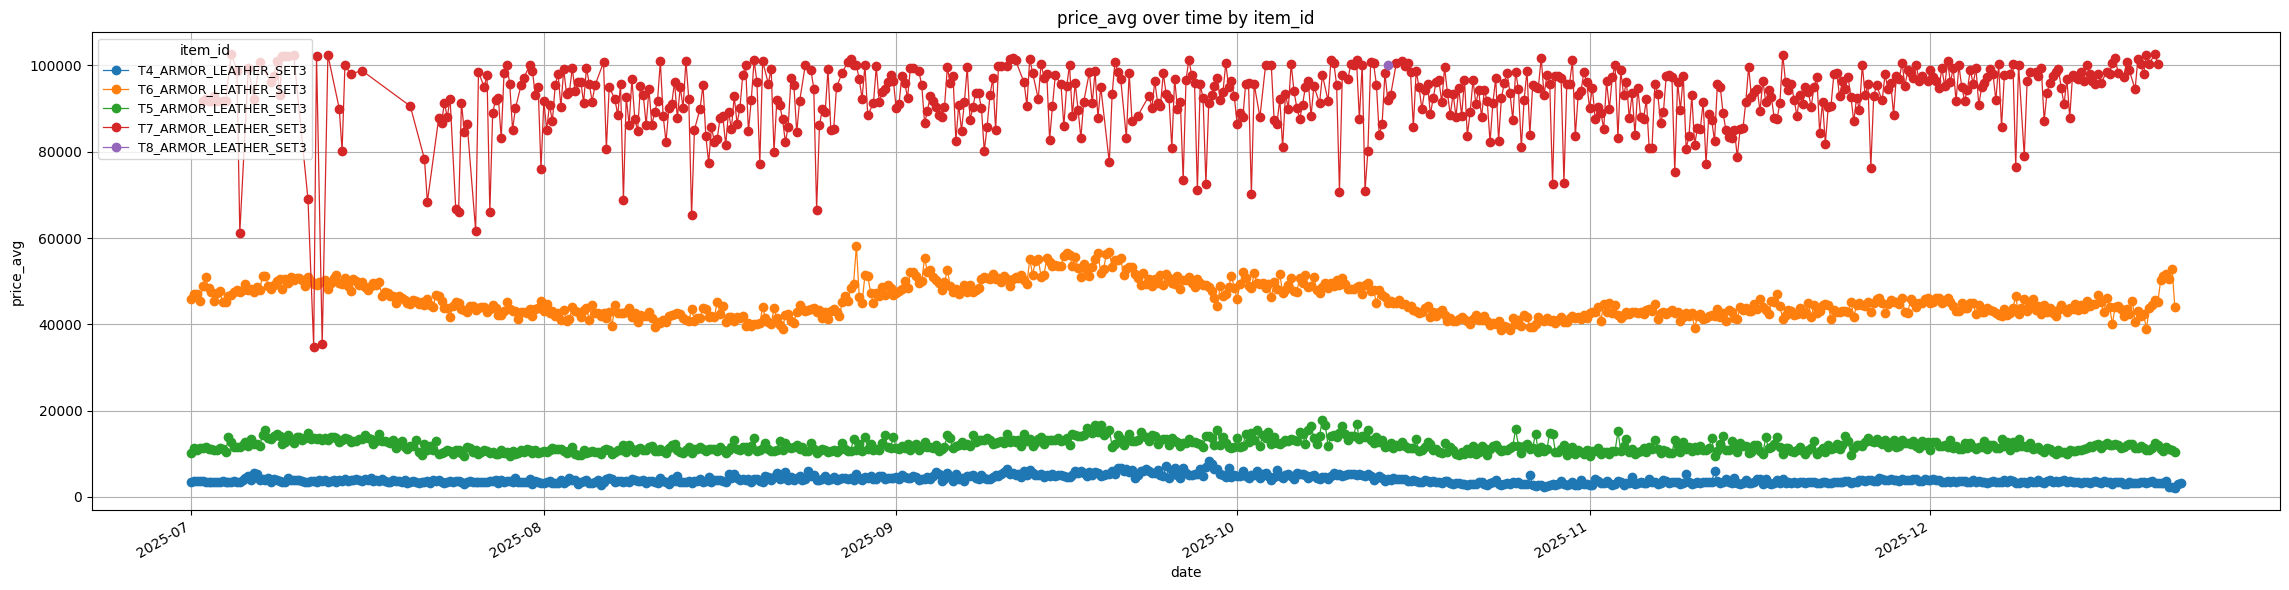

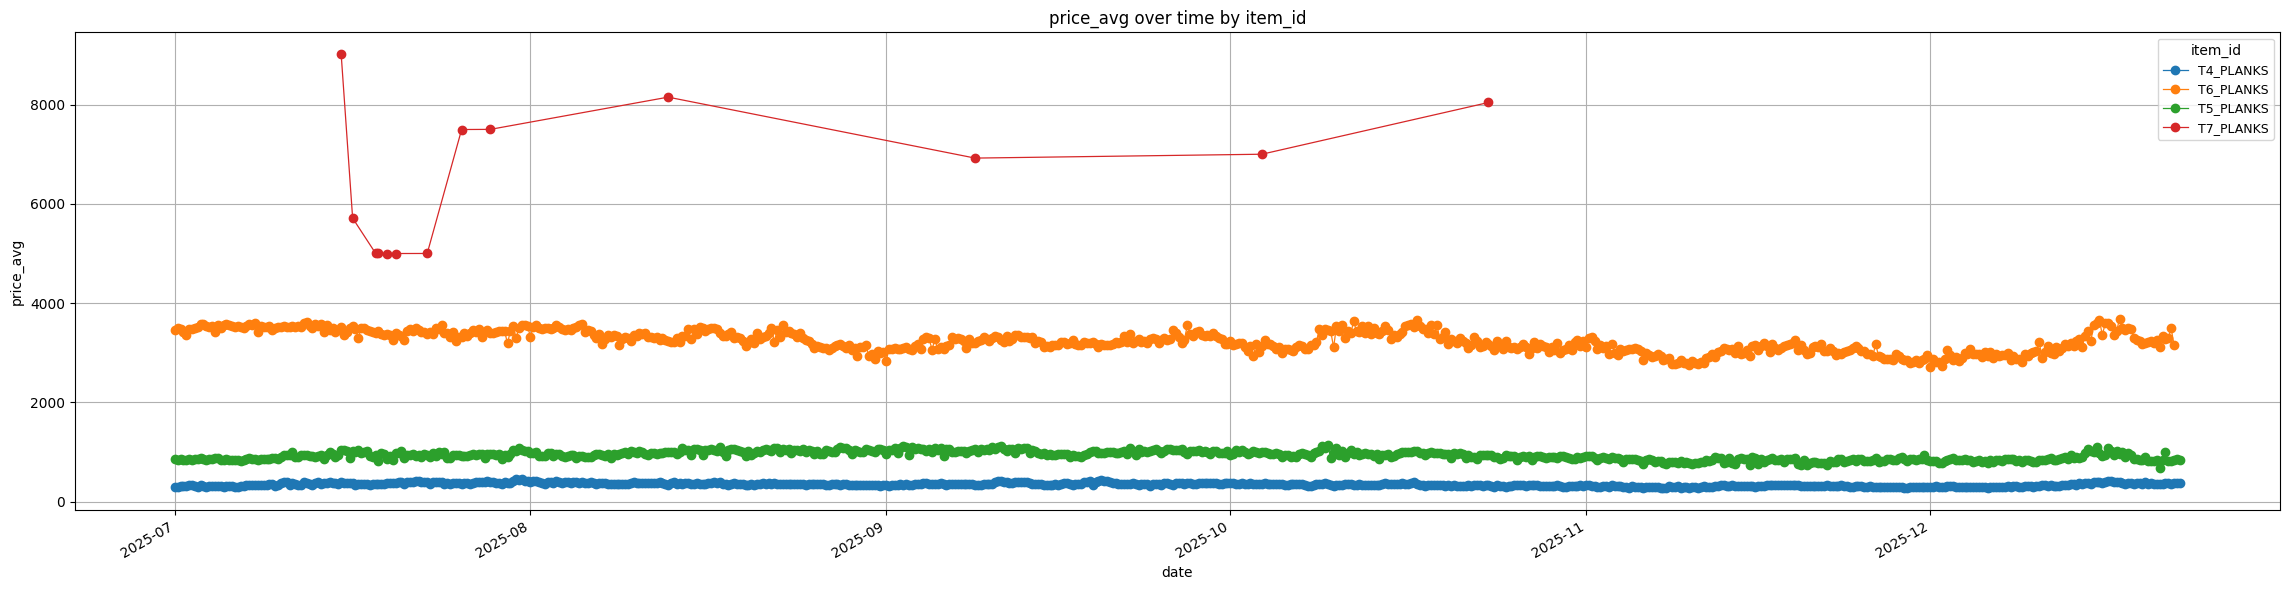

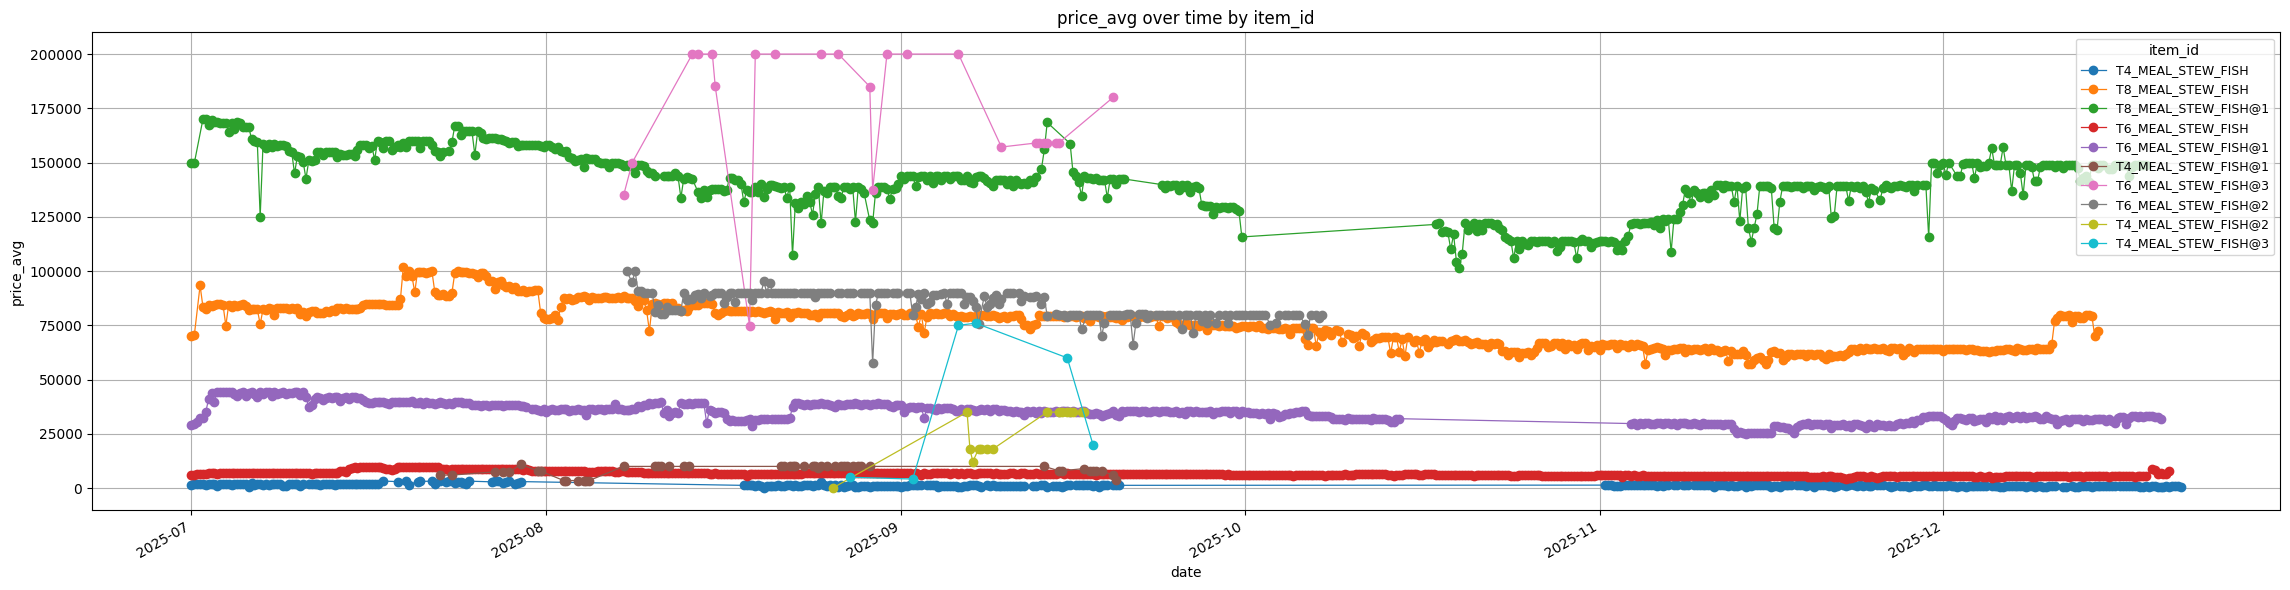

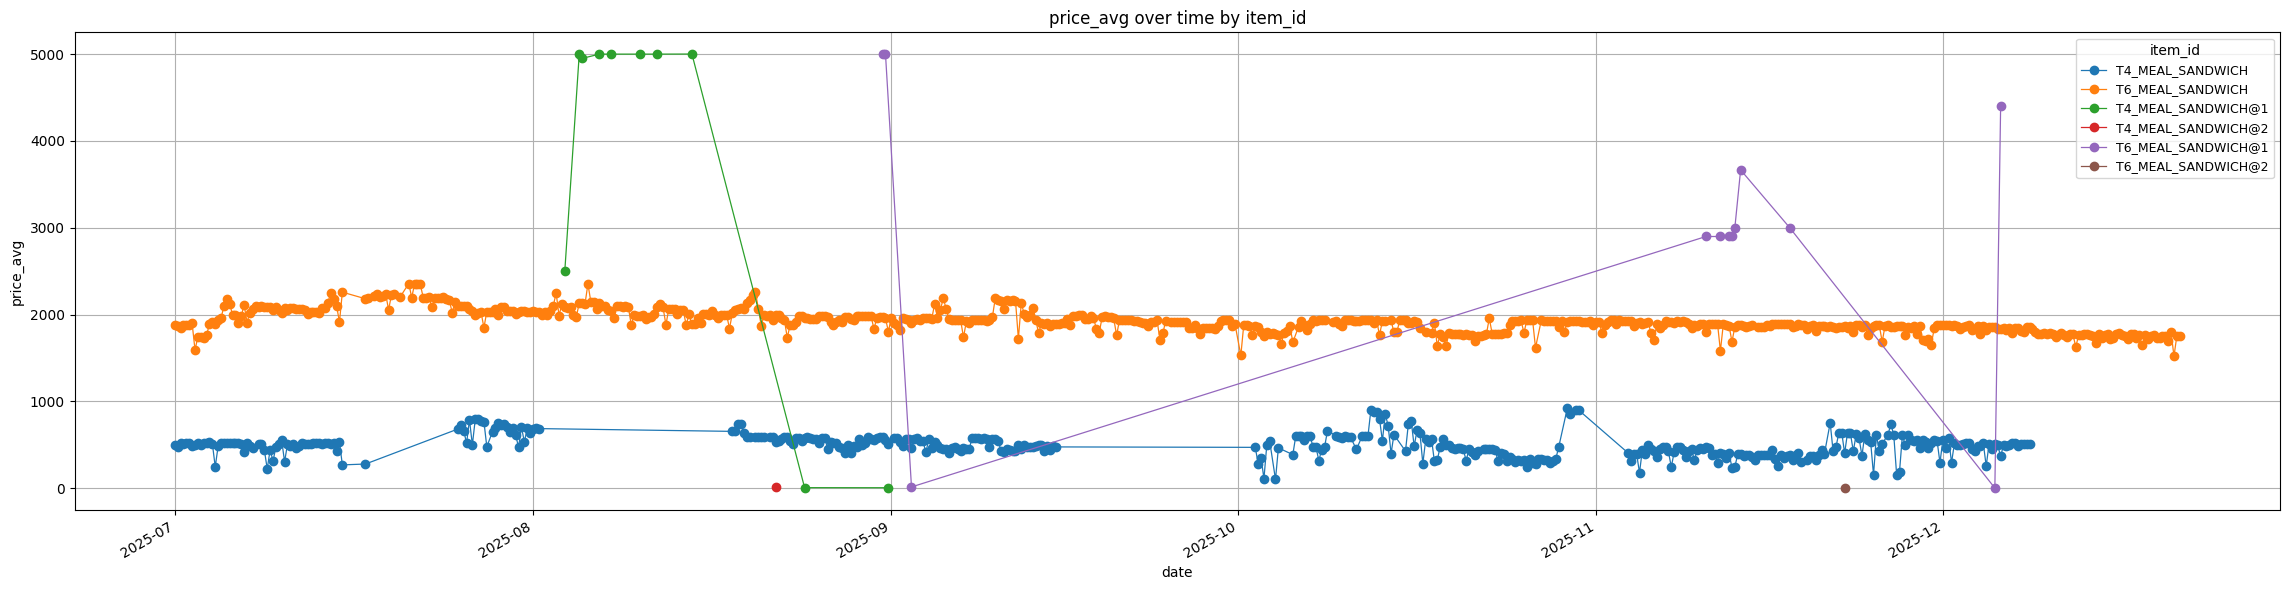

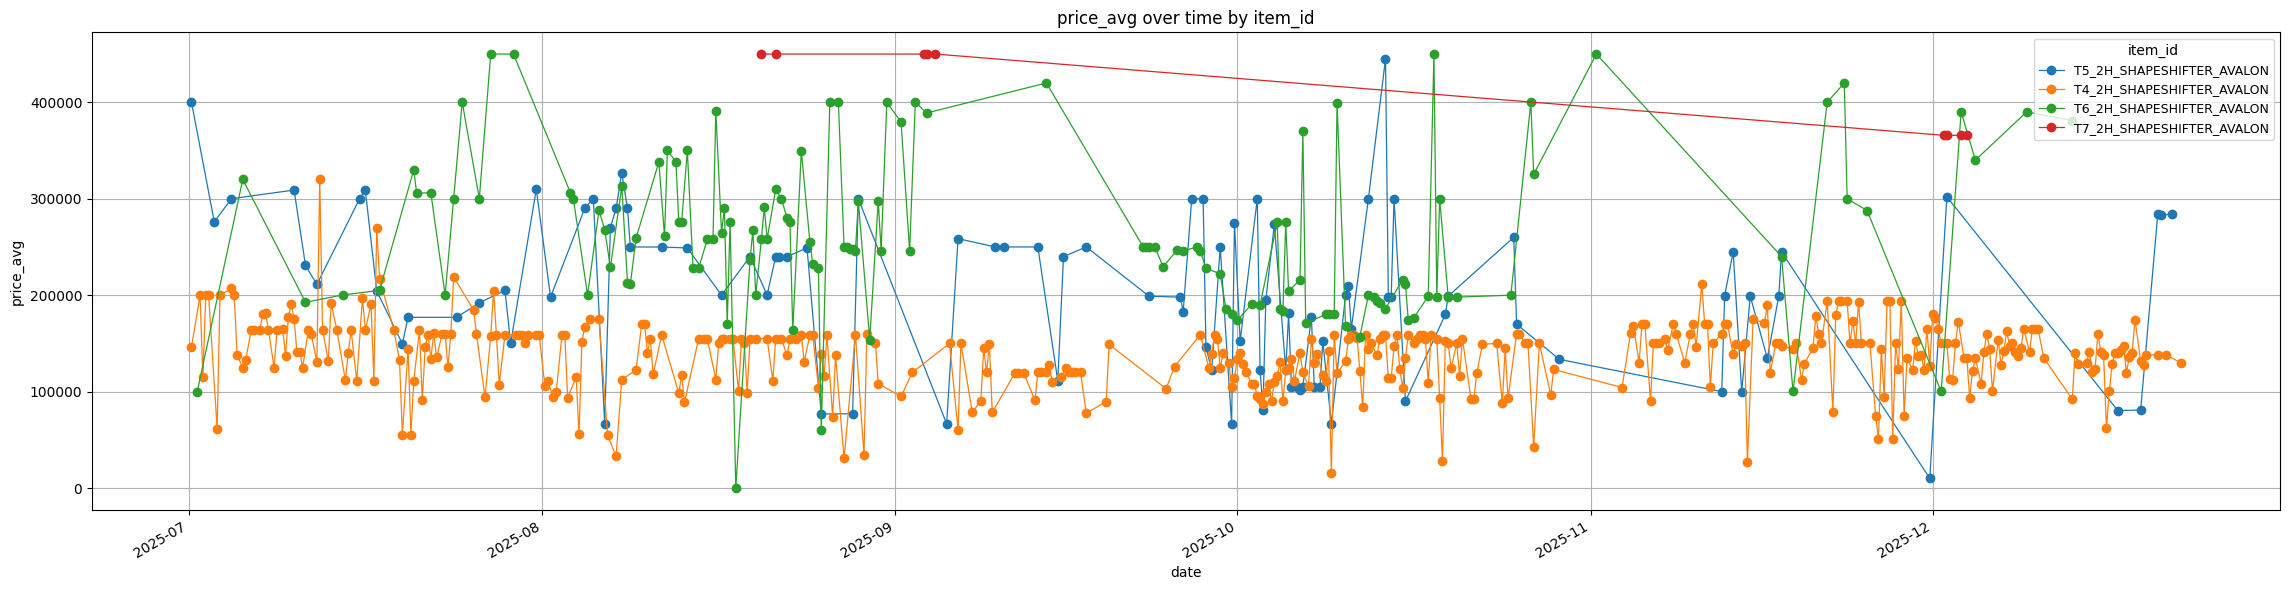

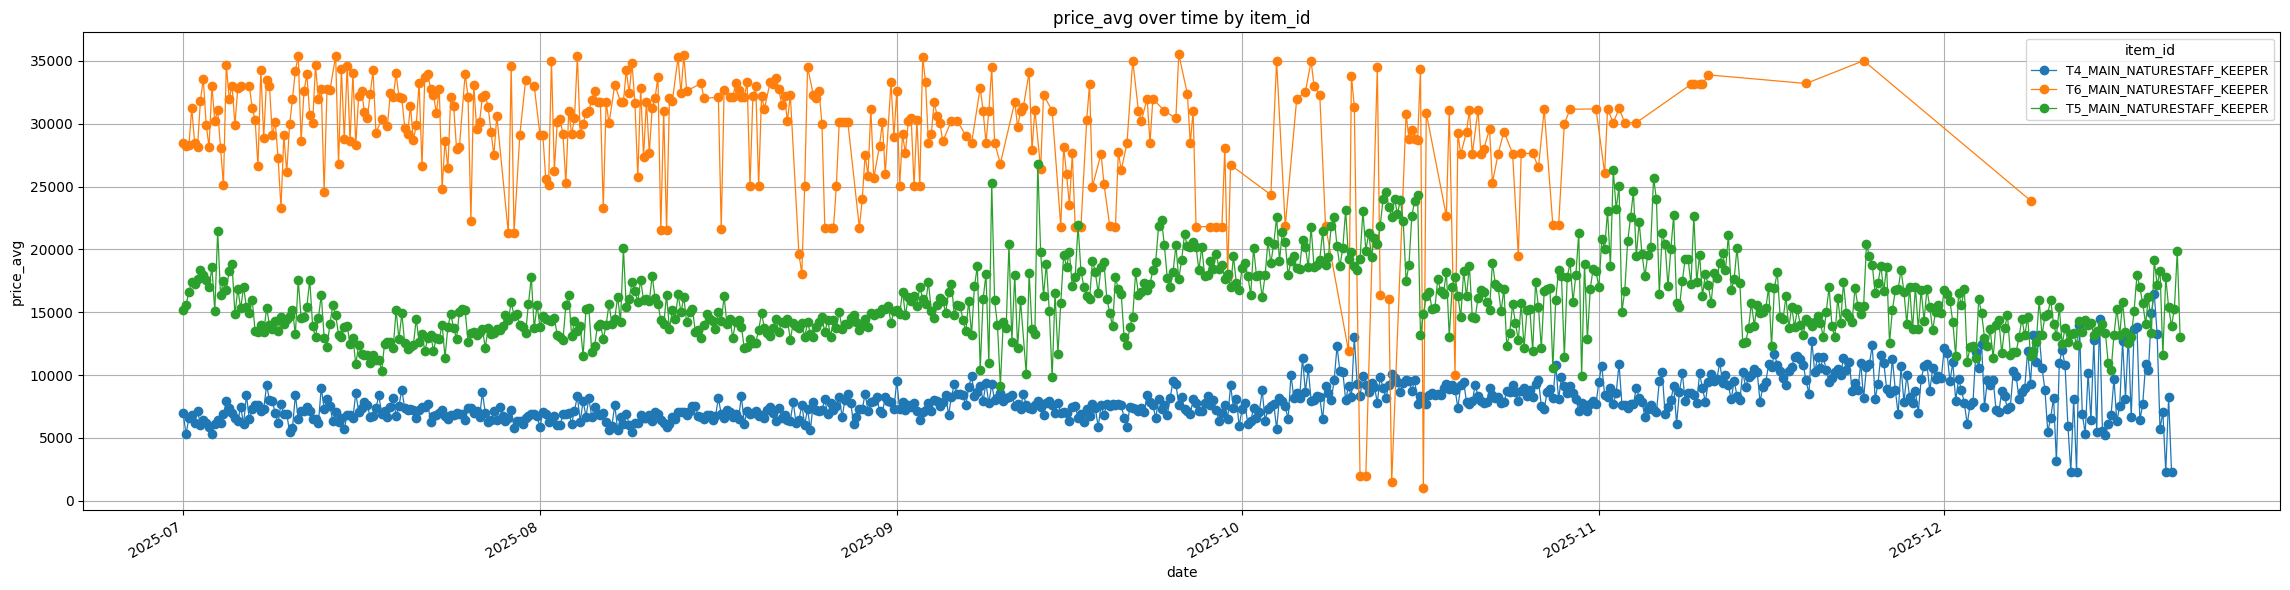

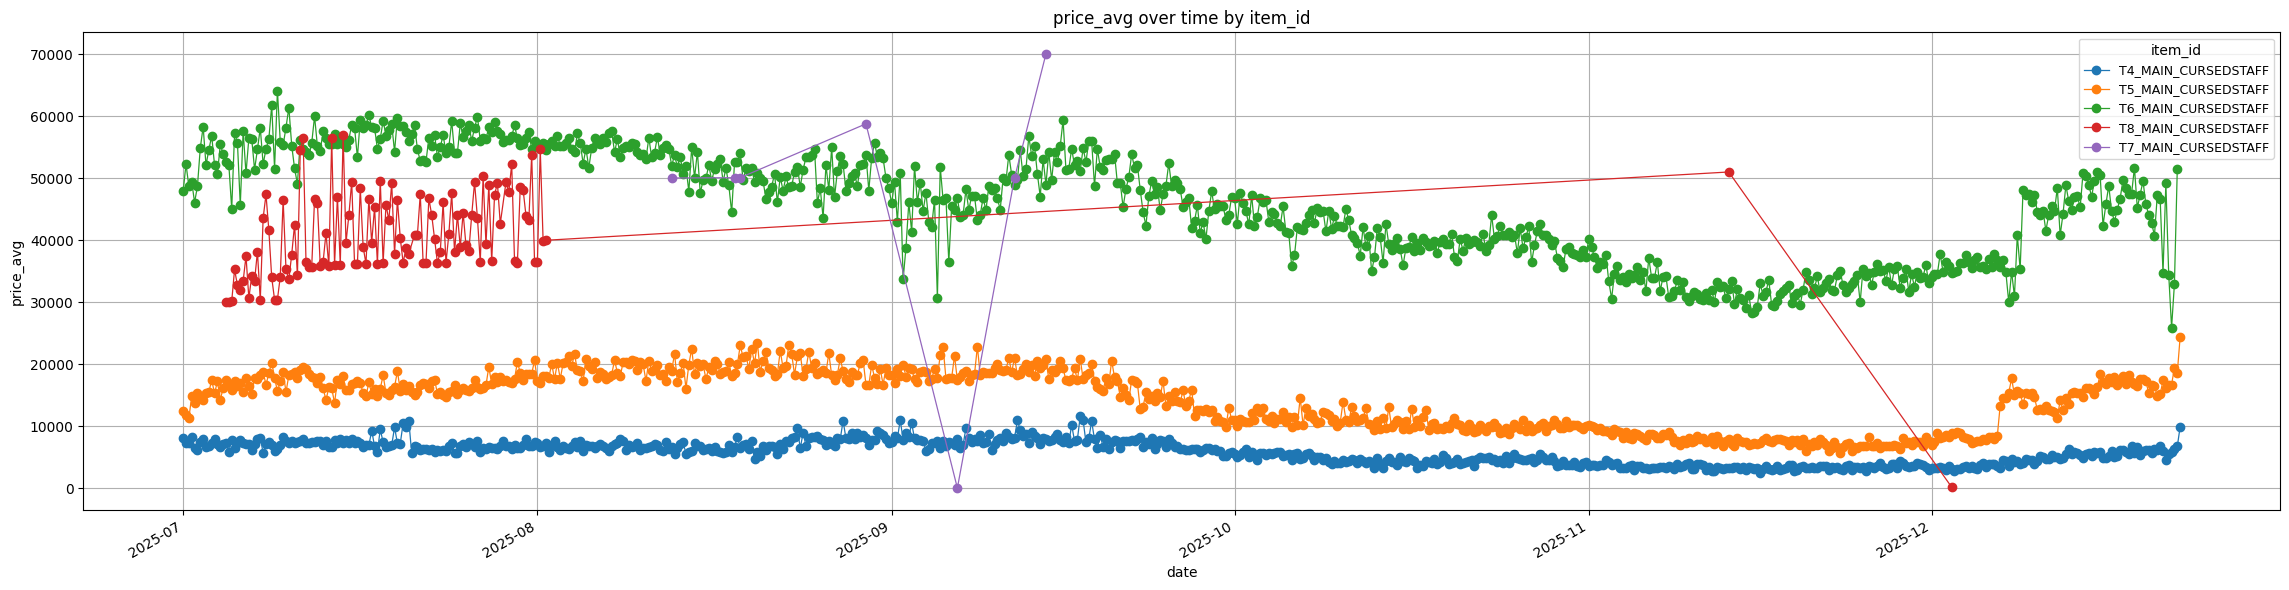

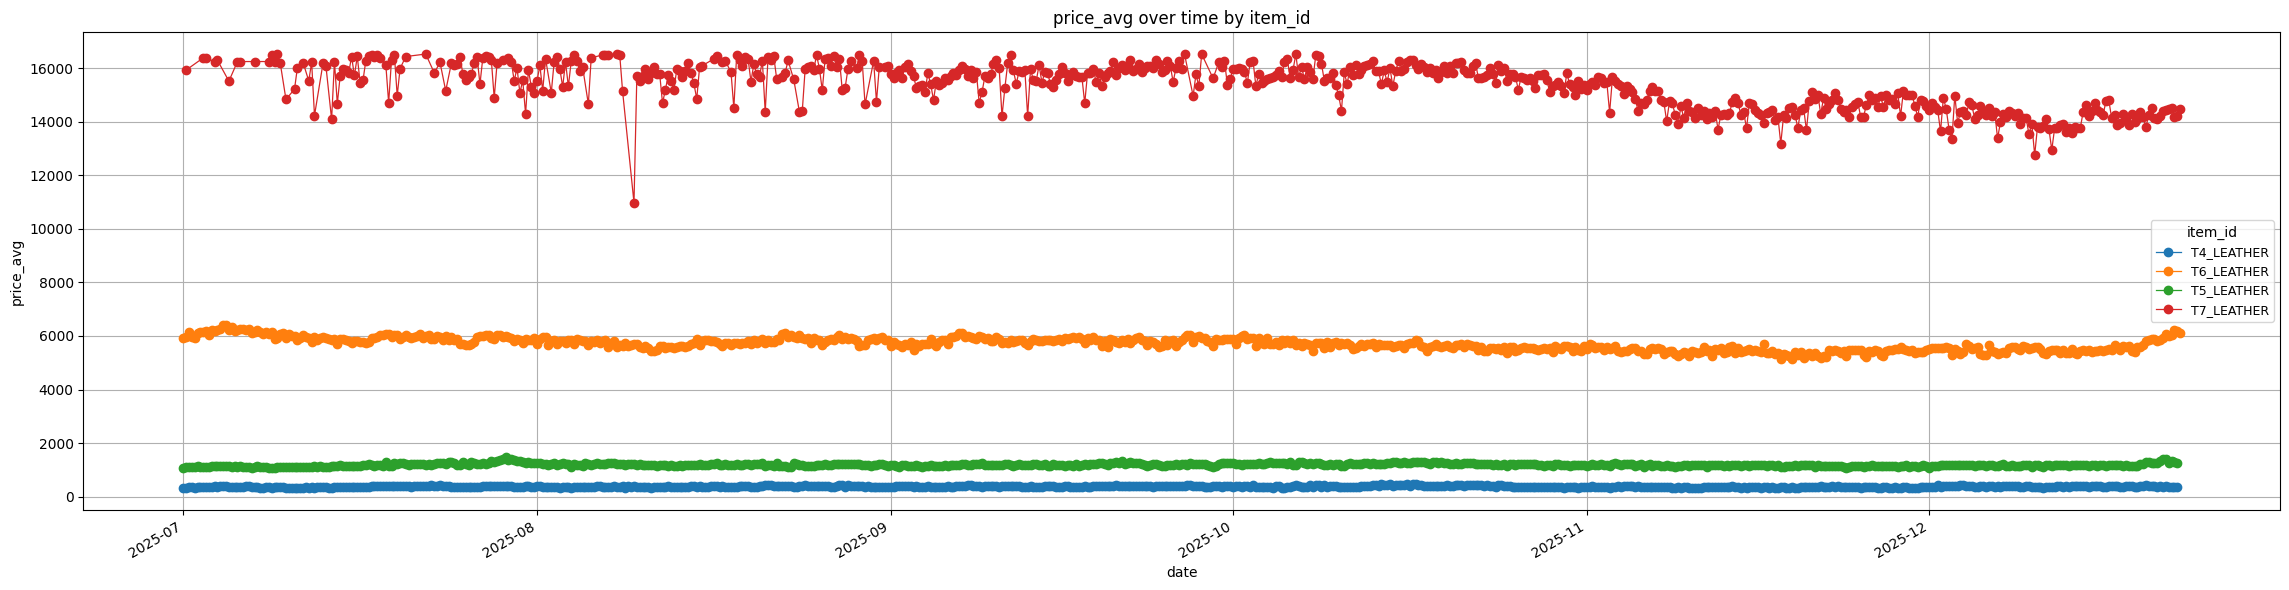

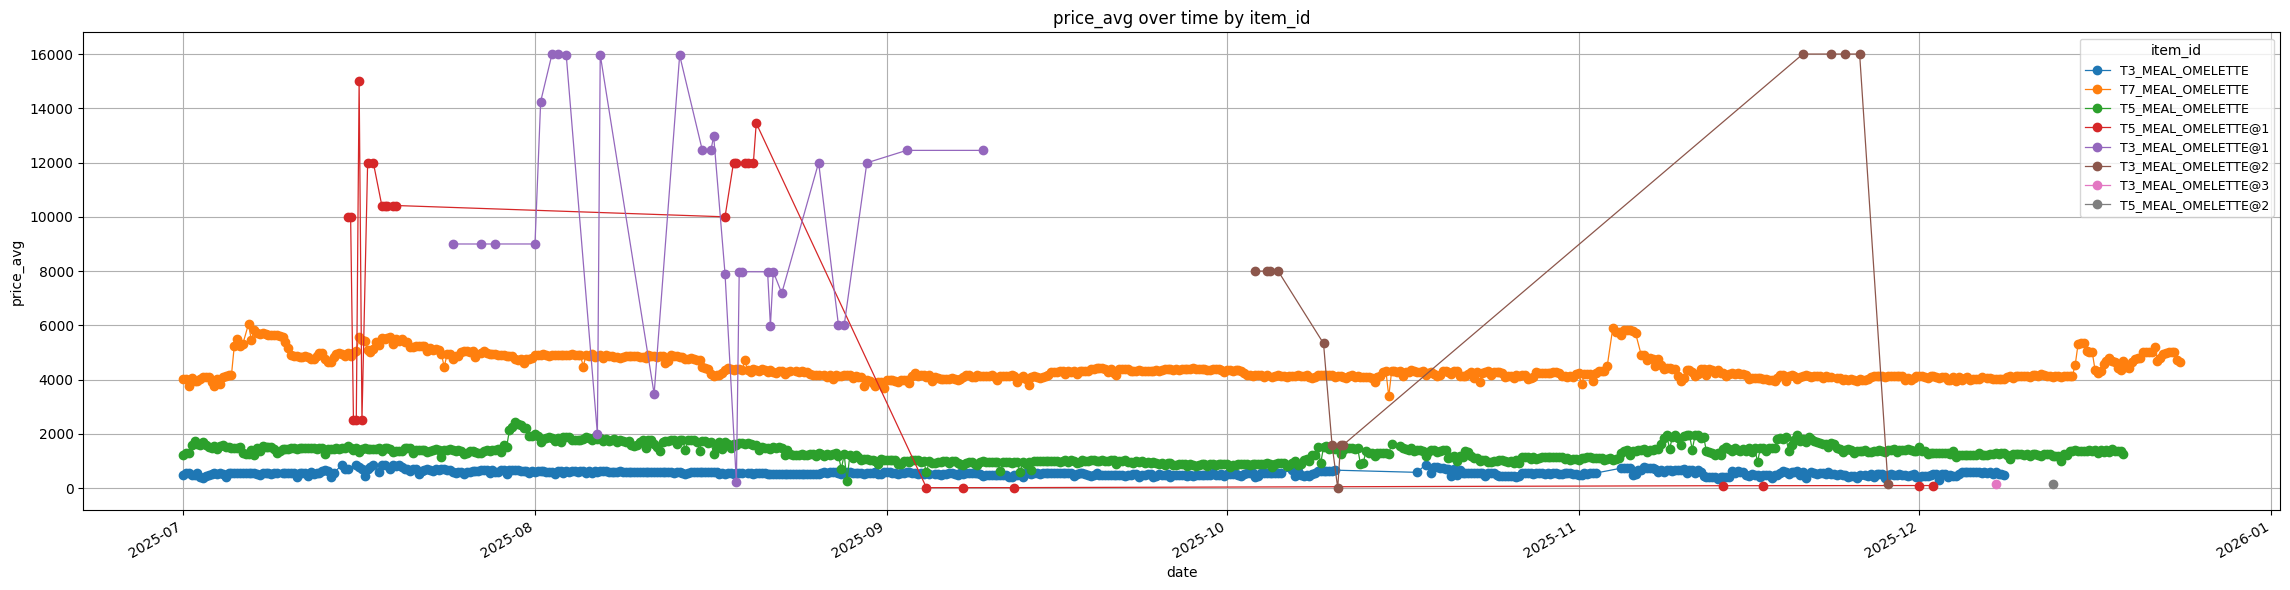

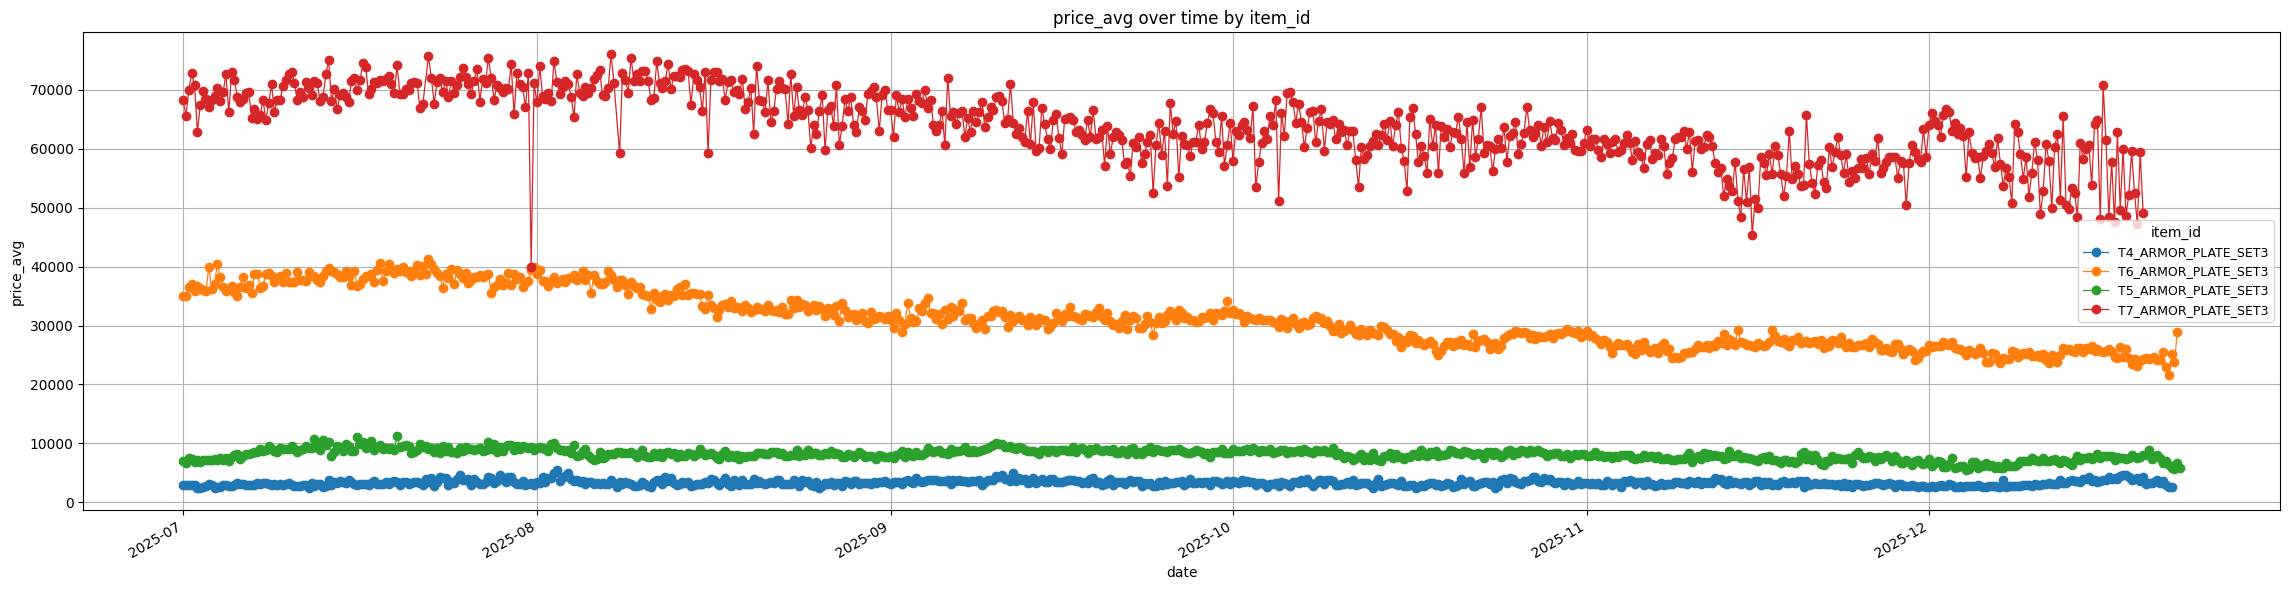

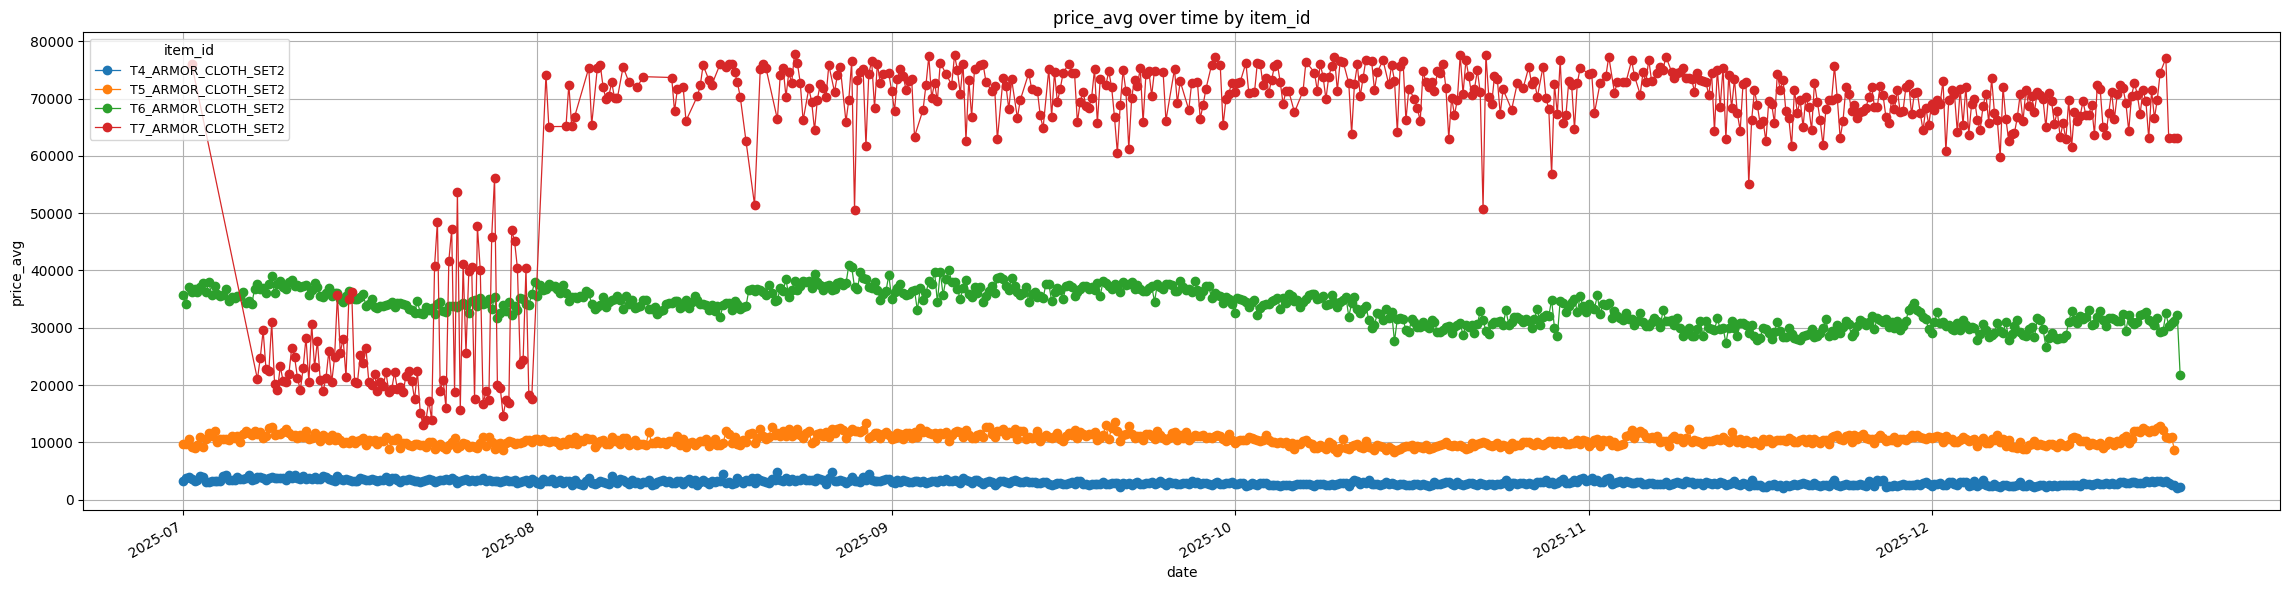

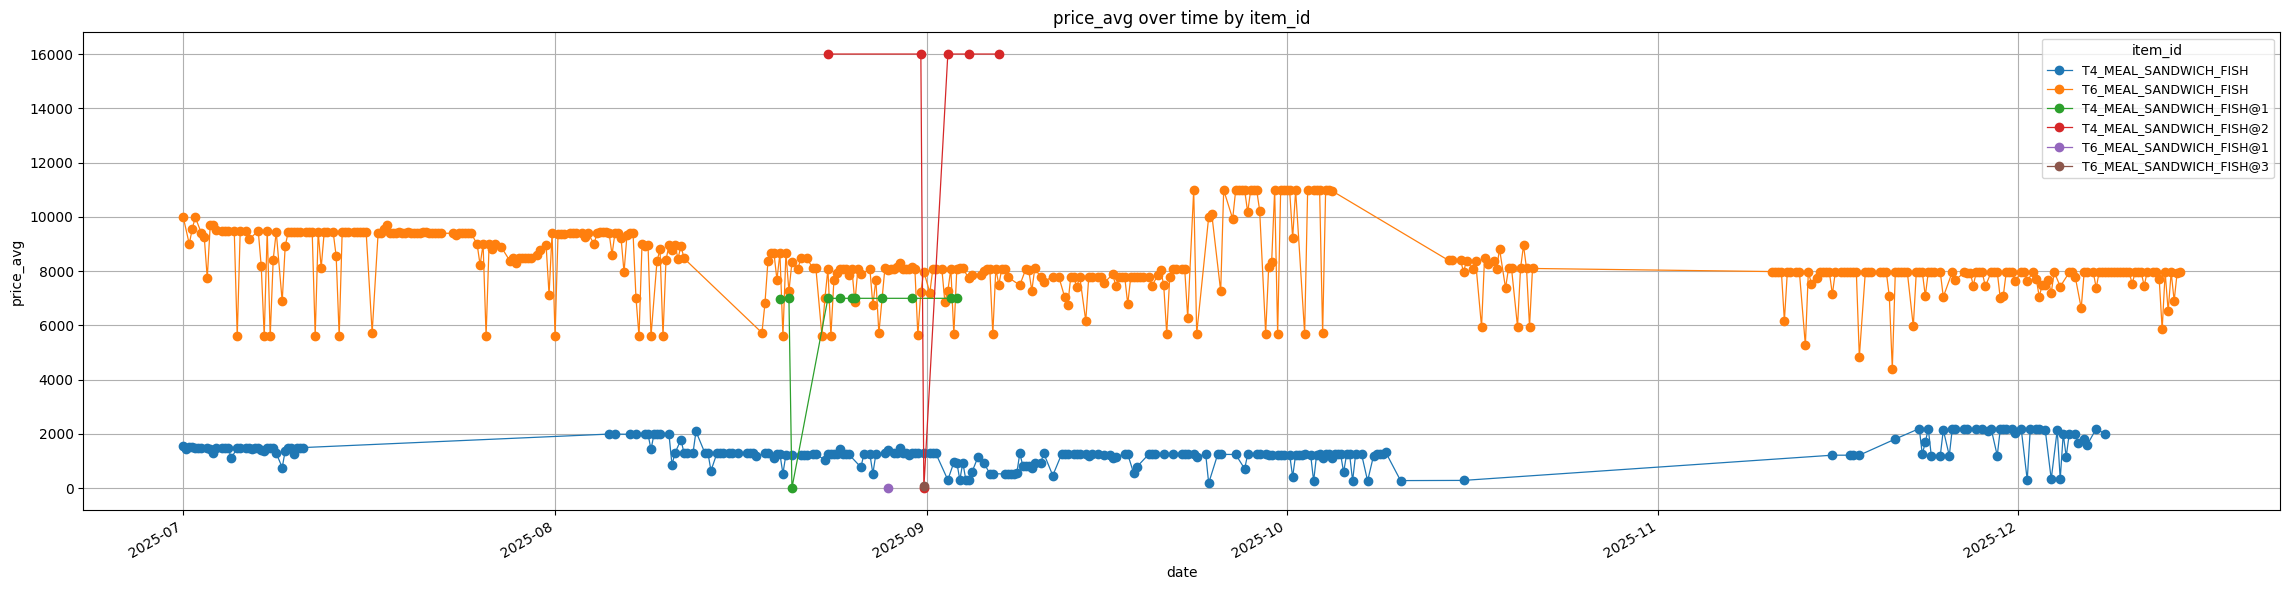

In [34]:
for csv_file in os.listdir("dfs"):
    if csv_file == "all.csv":
        continue
    df = pd.read_csv(os.path.join("dfs", csv_file))
    plot_prices_by_item(df if "MEAL" in csv_file else df[~df["item_id"].str.contains("@", case=False, na=False)]) # [df["item_id"] < "T6"]

In [58]:
dfs = []
for csv_file in os.listdir("dfs"):
    dfs.append(pd.read_csv(os.path.join("dfs", csv_file)))
r_df = pd.concat(dfs)
r_df.to_csv(os.path.join("dfs", "all.csv"))

In [62]:
r_df["timestamp"] = pd.to_datetime(r_df["timestamp"], errors="coerce")
r_df["price_avg"] = pd.to_numeric(r_df["price_avg"], errors="coerce")
r_df = r_df.dropna(subset=["timestamp", "price_avg", "item_id"])

t0 = r_df["timestamp"].min().floor("D")
t1 = r_df["timestamp"].max().floor("D")

first = r_df[(r_df["timestamp"] >= t0) & (r_df["timestamp"] < t0 + pd.Timedelta(days=7))]
last  = r_df[(r_df["timestamp"] >  t1 - pd.Timedelta(days=7)) & (r_df["timestamp"] <= t1)]

first_mean = first["price_avg"].mean()
last_mean  = last["price_avg"].mean()

print(first_mean, last_mean, round(last_mean / first_mean, 2))

224039.6457979894 193165.74100421014 0.86


In [5]:
import os
import pandas as pd
f_mean = []
l_mean = []
name = []

for csv_file in os.listdir("dfs"):
    t_df = pd.read_csv(os.path.join("dfs", csv_file))
    t_df["timestamp"] = pd.to_datetime(t_df["timestamp"], errors="coerce")
    t_df["price_avg"] = pd.to_numeric(t_df["price_avg"], errors="coerce")
    t_df = t_df.dropna(subset=["timestamp", "price_avg", "item_id"])

    t0 = t_df["timestamp"].min().floor("D")
    t1 = t_df["timestamp"].max().floor("D")

    first = t_df[(t_df["timestamp"] >= t0) & (t_df["timestamp"] < t0 + pd.Timedelta(days=7))]
    last  = t_df[(t_df["timestamp"] >  t1 - pd.Timedelta(days=7)) & (t_df["timestamp"] <= t1)]

    f_mean.append(first["price_avg"].mean())
    l_mean.append(last["price_avg"].mean())
    name.append(csv_file)

In [10]:
m_change = []
for i in range(len(f_mean)):
    m_change.append(round(l_mean[i] / f_mean[i], 2))
    print(name[i], f_mean[i], l_mean[i], round(l_mean[i] / f_mean[i], 2))

2H_ARCANESTAFF.csv 269400.1066624961 294165.6076732673 1.09
HIDE.csv 28487.970549566133 27469.692792437967 0.96
METALBAR.csv 111162.01542776999 94018.91496729512 0.85
ORE.csv 33990.888037567966 31791.3366114077 0.94
2H_CLAYMORE.csv 216474.03003842125 267409.20110957004 1.24
FIBER.csv 24672.858442601017 16235.153532608696 0.66
MAIN_HOLYSTAFF_AVALON.csv 514338.4656169666 396865.3425572519 0.77
WOOD.csv 30151.660271169098 21780.286551850495 0.72
2H_QUARTERSTAFF_AVALON.csv 261913.05981794538 248837.84672897196 0.95
2H_ICECRYSTAL_UNDEAD.csv 722688.2723965439 770327.570390554 1.07
2H_INFERNOSTAFF_MORGANA.csv 435411.2172509225 543964.3144599303 1.25
BAG.csv 376100.7091953177 265700.19000626565 0.71
all.csv 224039.6457979894 193165.74100421014 0.86
CLOTH.csv 83780.91145677536 34142.165020337015 0.41
2H_LONGBOW.csv 251865.52560842718 306591.574940048 1.22
ARMOR_LEATHER_SET3.csv 195425.49205448353 204103.39522628643 1.04
PLANKS.csv 95759.73403942336 58820.65971860344 0.61
2H_SHAPESHIFTER_AVALON.

In [11]:
sum(m_change) / len(m_change)

np.float64(0.9004347826086957)